# [Lecture 16 - Gaussian Processes](https://youtu.be/Y2ZLt4iOrXU?si=NN2oor2yEz3YSoLY)

In [1]:
%run init_notebook.py

Module aliases imported by init_notebook.py:
--------------------------------------------
import numpy as np

import pandas as pd

import statsmodels.formula.api as smf

import pymc as pm

import xarray as xr

import arviz as az

import utils as utils

from scipy import stats as stats

from matplotlib import pyplot as plt

Watermark:
----------
Last updated: 2024-06-24T08:31:33.960152+09:00

Python implementation: CPython
Python version       : 3.11.9
IPython version      : 8.25.0

Compiler    : GCC 12.3.0
OS          : Linux
Release     : 6.6.25-01713-g2f237acc8e50
Machine     : x86_64
Processor   : 
CPU cores   : 4
Architecture: 64bit

matplotlib : 3.8.4
pandas     : 2.2.2
arviz      : 0.18.0
scipy      : 1.13.1
xarray     : 2024.6.0
numpy      : 1.26.4
statsmodels: 0.14.2
pymc       : 5.15.1



In [2]:
import pymc as pm
import arviz as az
import numpy as np
import networkx as nx
from scipy import stats as stats

# Returning to Oceanic Technology Dataset

We'll now deal with some of the confounds we glossed over, now that we have some more advanced statistical tools

In [3]:
KLINE = utils.load_data("Kline2")
KLINE

,culture,population,contact,total_tools,mean_TU,lat,lon,lon2,logpop
0,Malekula,1100,low,13,3.2,-16.3,167.5,-12.5,7.003065
1,Tikopia,1500,low,22,4.7,-12.3,168.8,-11.2,7.313220
2,Santa Cruz,3600,low,24,4.0,-10.7,166.0,-14.0,8.188689
3,Yap,4791,high,43,5.0,9.5,138.1,-41.9,8.474494
4,Lau Fiji,7400,high,33,5.0,-17.7,178.1,-1.9,8.909235
5,Trobriand,8000,high,19,4.0,-8.7,150.9,-29.1,8.987197
6,Chuuk,9200,high,40,3.8,7.4,151.6,-28.4,9.126959
7,Manus,13000,low,28,6.6,-2.1,146.9,-33.1,9.472705
8,Tonga,17500,high,55,5.4,-21.2,-175.2,4.8,9.769956
9,Hawaii,275000,low,71,6.6,19.9,-155.6,24.4,12.524526


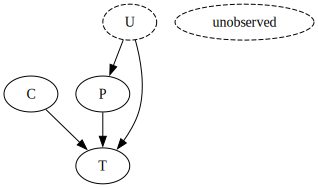

In [4]:
utils.draw_causal_graph(
    edge_list=[
        ("P", "T"),
        ("C", "T"),
        ("U", "T"),
        ("U", "P")
    ],
    node_props={
        "U": {"style": "dashed"},
        "unobserved": {"style": "dashed"}
    }
)

- Total tools in society $T$ (outcome)
- Populuation $P$ (treatment)
- Contact level $C$
- Unobserved confounds $U$, e.g.
  - materials
  - weather

There should be **spatial covariation**: 
- islands closer to one another should have similar unobserved confounds
- islands should share historical context
- we don't have to know the exact dymanics of the contexts, we can handle statistically at a macro scale


## Review of Techonological Innovation/Loss model

- Derived from steady state of difference equation $\Delta T = \alpha P^ \beta - \gamma T$
  - $\alpha$ is rate of innovation
  - $P$ is population
  - $\beta$ is elasticity rate (diminishing returns)
  - $\gamma$ is loss (e.g. forgetting) rate over time
- Provides the expected number of tools over the long-run:
  - $\hat T = \frac{\alpha P ^ \beta}{\gamma}$
  - use $\lambda= \hat T$ as the expected rate parameter for a $\text{Poisson}(\lambda)$ distribution
- **How can we encode spatial covariance in this model?**

## Let's start of with an easier model that ignores population

$$
\begin{align*}
    T_i &\sim \text{Poisson}(\lambda_i) \\
    \lambda_i &= \bar \alpha + \alpha_{S[i]} \\
    \begin{pmatrix}
        \alpha_1 \\
        \alpha_2 \\
        \vdots \\
        \alpha_{10}
    \end{pmatrix} &= \text{MVNormal}
    \left( 
        \begin{bmatrix}
            0 \\
            0 \\
            \vdots \\
            0
        \end{bmatrix}, \textbf{K}
    \right)
\end{align*}
$$

- $\alpha_{S[i]}$ are the variable intercepts for each society
  - These will have covariation based on their spatial distance from one another
  - closer societies have similar offsets
- $\mathbf{K}$ the covariance amongst societies
  - models covariance as a function distance
  - though $\mathbf{K}$ has many parameters (45 covariances), we should be able to leverage spatial regularity to estimate far fewer effective parameters. This is good b.c. we only have 10 data points 😅


# Gaussian Processes (in the abstract)

- Uses a **kernel function** to generate covariance matrices
  - Requires far fewer parameters than the covariance matrix entries
  - Can generate covariance matrices of any dimenions (i.e. "infinite dimensional generalization of the `MNNormal`")
  - Can generate a prediction for any point


- Kernel function calculates the covariance of two points based on metric of comparison, e.g.
  - spatial distance
  - difference in time
  - difference in age

## Different Kernel Functions

In [5]:
def plot_kernel_function(
    kernel_function,
    max_distance=1,
    resolution=100,
    label=None,
    ax=None,
    **line_kwargs
):
    """Helper to plot a kernel function"""
    X = np.linspace(0, max_distance, resolution)[:, None]
    covariance = kernel_function(X, X)
    distances = np.linspace(0, max_distance, resolution)
    if ax is not None:
        plt.sca(ax)
    utils.plot_line(distances, covariance[0, :], label=label, **line_kwargs)
    plt.xlim([0, max_distance])
    plt.ylim([-0.05, 1.05])
    plt.xlabel("|X1-X2|")
    plt.ylabel("covariance")
    if label is not None:
        plt.legend()
    

### The Quadratic (L2) Kernel Function
- aka RGB
- aka Gaussian Kernel

$$
K(x_i, x_j) = \eta^2 \exp \left(- \frac{(x_i - x_j)^2}{\sigma^2} \right)
$$

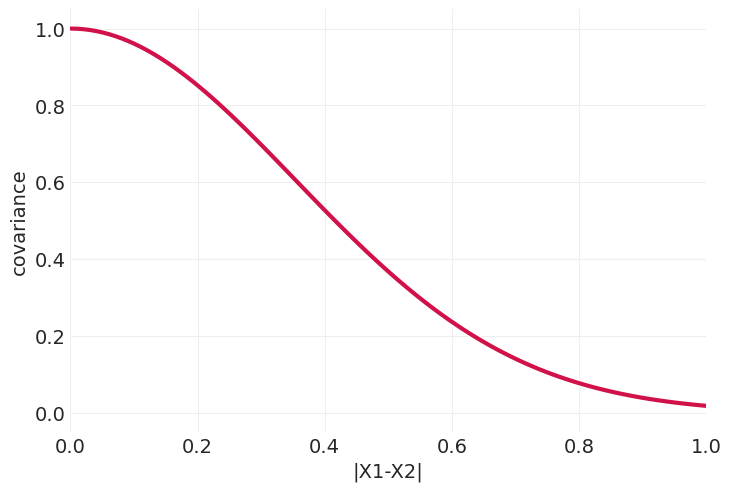

In [6]:
def quadratic_distance_kernel(X0, X1, eta=1, sigma=.5):
    # Use linear algebra identity: ||x-y||^2 = ||x||^2 + ||y||^2 - 2 * x^T * y
    X0_norm = np.sum(X0 ** 2, axis=-1)
    X1_norm = np.sum(X1 ** 2, axis=-1)
    squared_distances = X0_norm[:, None] + X1_norm[None, :] - 2 * X0 @ X1.T
    rho = 1 / sigma ** 2
    return eta ** 2 * np.exp(-rho * squared_distances)

plot_kernel_function(quadratic_distance_kernel)

### Ornstein-Uhlenbeck Kernel

$$
\begin{align*}
K(x_i, x_j) &= \eta^2 \exp \left(- \frac{|x_i - x_j|}{\sigma} \right) \\
\sigma &= \frac{1}{\rho}
\end{align*}
$$

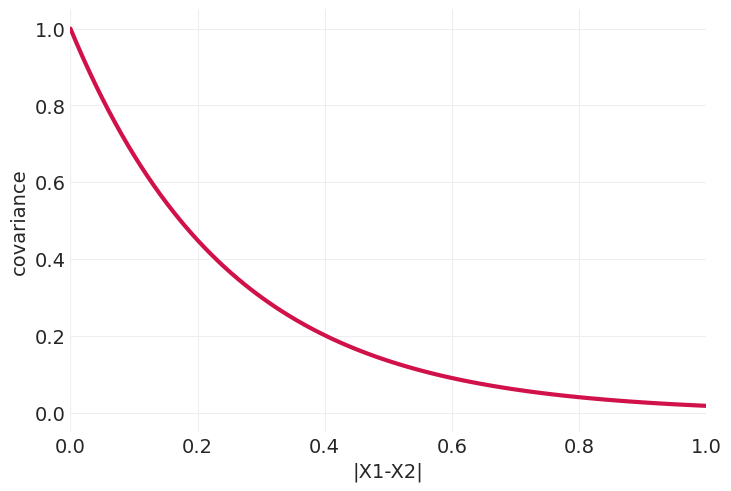

In [7]:
def ornstein_uhlenbeck_kernel(X0, X1, eta_squared=1, rho=4):
    distances = np.abs(X1[None, :] - X0[:, None])
    return eta_squared * np.exp(-rho * distances)

plot_kernel_function(ornstein_uhlenbeck_kernel)

### Periodic Kernel

$$
K(x_i, x_j) = \eta^2 \exp \left(- \frac{\sin^2((x_i - x_j) / p)}{\sigma^2} \right)
$$

with additional periodicity parameter, $p$

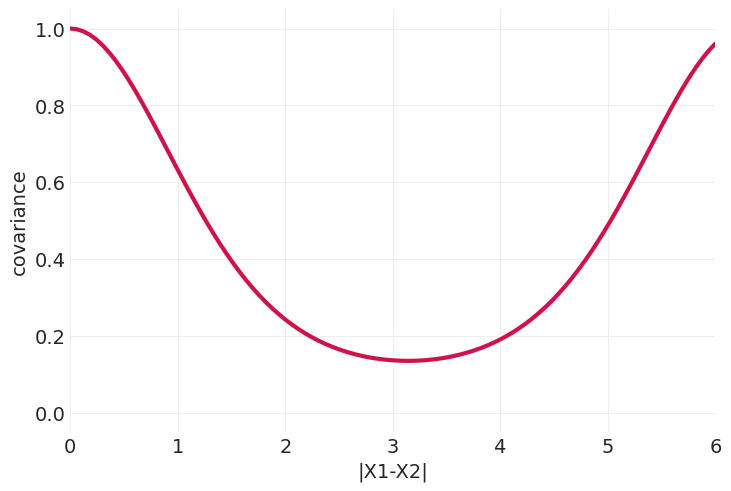

In [8]:
def periodic_kernel(X0, X1, eta=1, sigma=1, periodicity=.5):
    distances = np.sin((X1[None, :] - X0[:, None]) * periodicity) ** 2
    rho = 2 / sigma ** 2
    return eta ** 2 * np.exp(-rho * distances)

plot_kernel_function(periodic_kernel, max_distance=6)

### Gaussian Process Prior

Using the Gaussian/L2 Kernel Function to generate our covariance $\mathbf{K}$, we can adjust a few parameters

- Varying $\sigma$ controls the bandwidth of the kernel function
  - smaller $\sigma$ makes covariance fall off quickly with space
  - larger $\sigma$ allow covariance to extend larger distances

- Varying $\eta$ controls the maximum degree of covariance

#### 1-D Examples
Below we draw functions from a 1-D Guassian process, varying either $\sigma$ or $\eta$ to demonstrate the effect of the parameters on the spatial correlation of the samples.

In [9]:
# Helper functions 
def plot_gaussian_process(
    X,
    samples=None,
    mean=None,
    cov=None,
    X_obs=None,
    Y_obs=None,
    uncertainty_prob=.89
):
    X = X.ravel()

    # Plot GP samples
    for ii, sample in enumerate(samples):
        label = "GP samples" if not ii else None
        utils.plot_line(X, sample, color=f"C{ii}", linewidth=1, label=label)
        
    # Add GP mean, if provided
    if mean is not None:
        mean = mean.ravel()
        utils.plot_line(X, mean, color='k', label='GP mean')

        # Add uncertainty around mean; requires covariance matrix
        if cov is not None:
            z = stats.norm.ppf(1 - (1 - uncertainty_prob) / 2)
            uncertainty = z * np.sqrt(np.diag(cov))
            plt.fill_between(
                X,
                mean + uncertainty,
                mean - uncertainty,
                alpha=0.1,
                color='gray',
                zorder=1,
                label='GP uncertainty'
            )

    # Add any training data points, if provided
    if X_obs is not None:
        utils.plot_scatter(X_obs, Y_obs, color='k', label='observations', zorder=100, alpha=1)
        
    plt.xlim([X.min(), X.max()])
    plt.ylim([-5, 5])
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()

    
def plot_gaussian_process_prior(kernel_function, n_samples=3, figsize=(10, 5), resolution=100):
    X = np.linspace(-5, 5, resolution)[:, None]
    
    prior = gaussian_process_prior(X, kernel_function)
    samples = prior.rvs(n_samples)

    _, axs = plt.subplots(1, 2, figsize=figsize)
    plt.sca(axs[0])
    plot_gaussian_process(X, samples=samples)
    
    plt.sca(axs[1])
    plot_kernel_function(kernel_function, color='k')
    plt.title(f"kernel function")
    return axs

def gaussian_process_prior(X_pred, kernel_function):
    """Initializes a Gaussian Process prior distribution for provided Kernel function"""
    mean = np.zeros(X_pred.shape).ravel()
    cov = kernel_function(X_pred, X_pred)
    return stats.multivariate_normal(mean=mean, cov=cov, allow_singular=True)

#### Varying $\sigma$

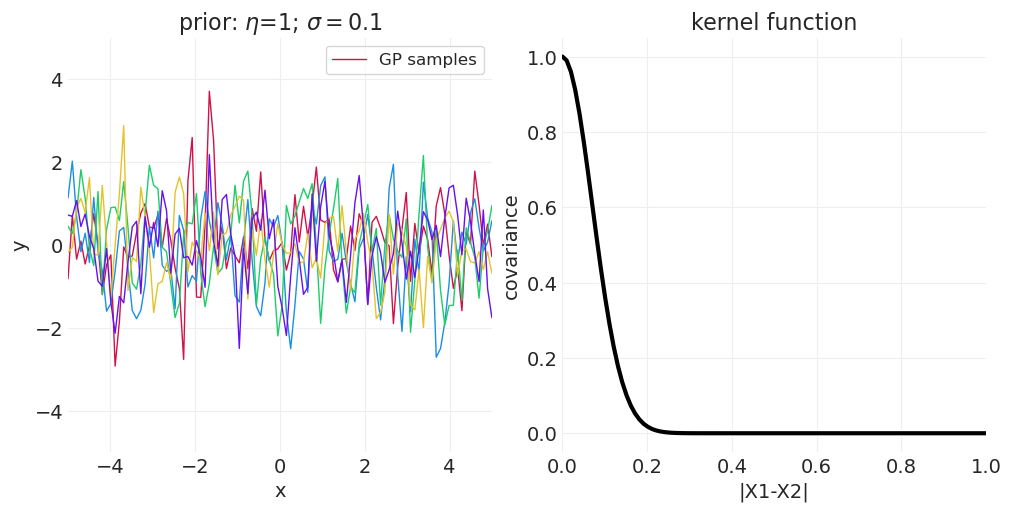

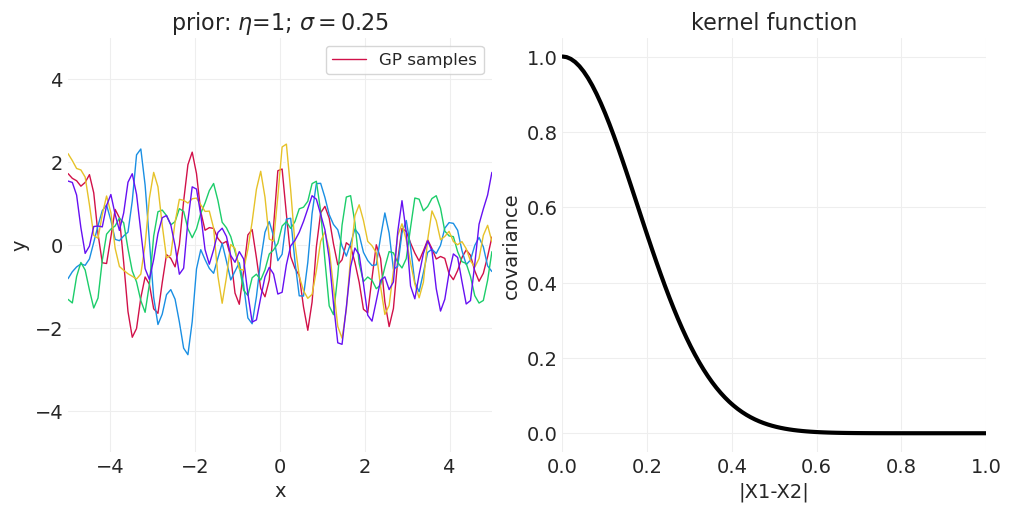

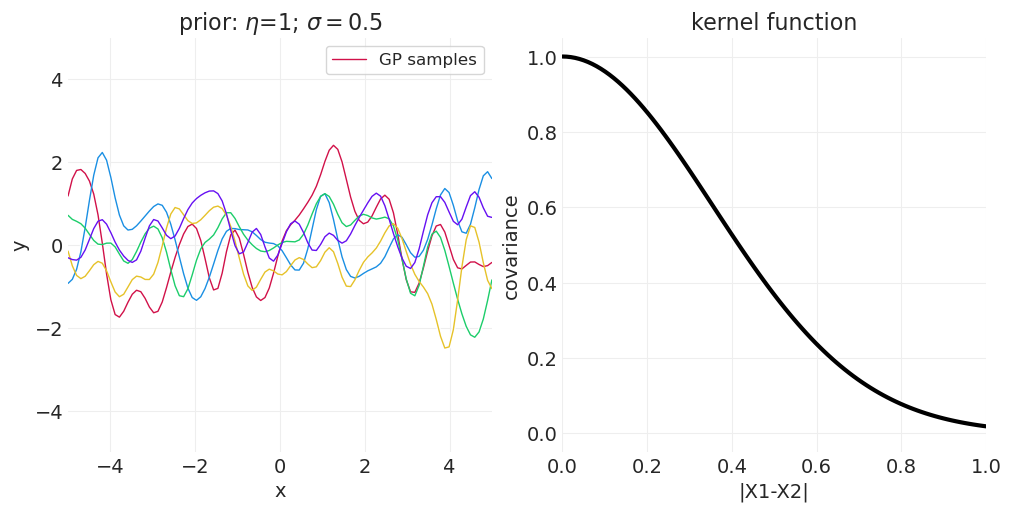

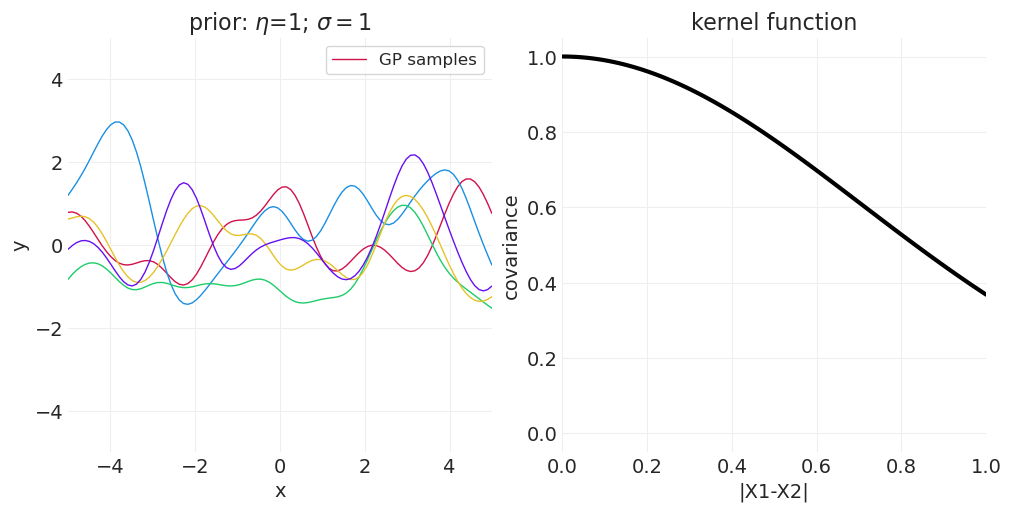

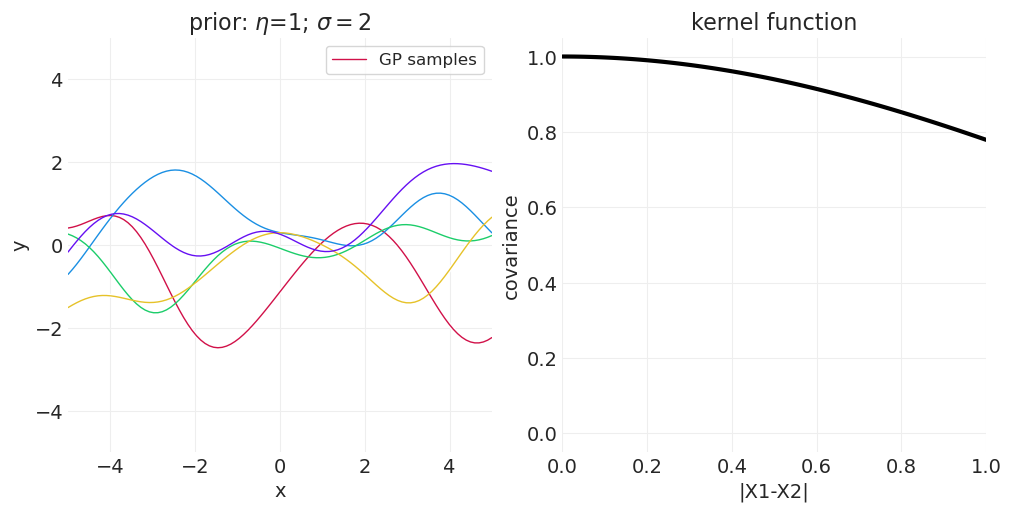

In [13]:
from functools import partial

eta = 1
for sigma in [0.1, .25, .5, 1, 2]:
    kernel_function = partial(quadratic_distance_kernel, eta=eta, sigma=sigma)
    axs = plot_gaussian_process_prior(kernel_function, n_samples=5)
    axs[0].set_title(f"prior: $\\eta$={eta}; $\\sigma=${sigma}")

#### Varying $\eta$

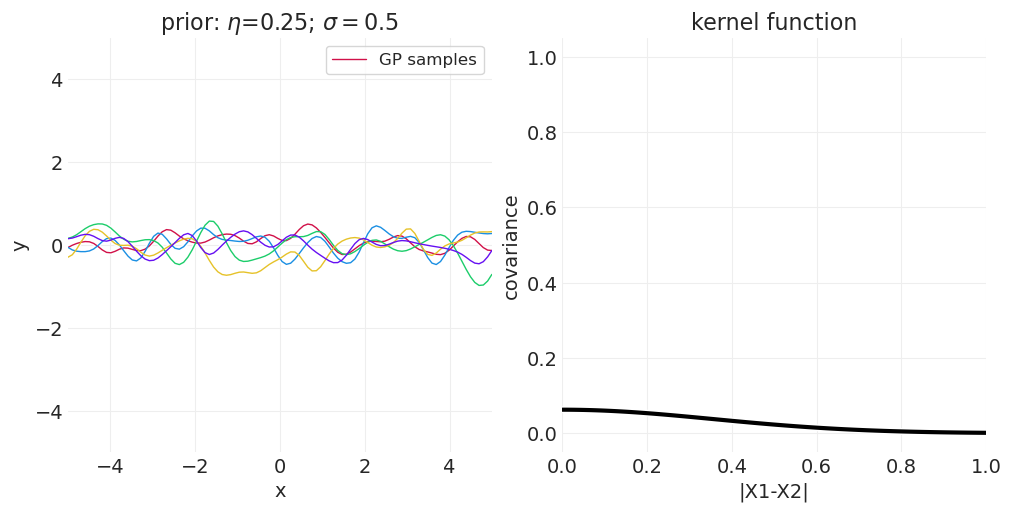

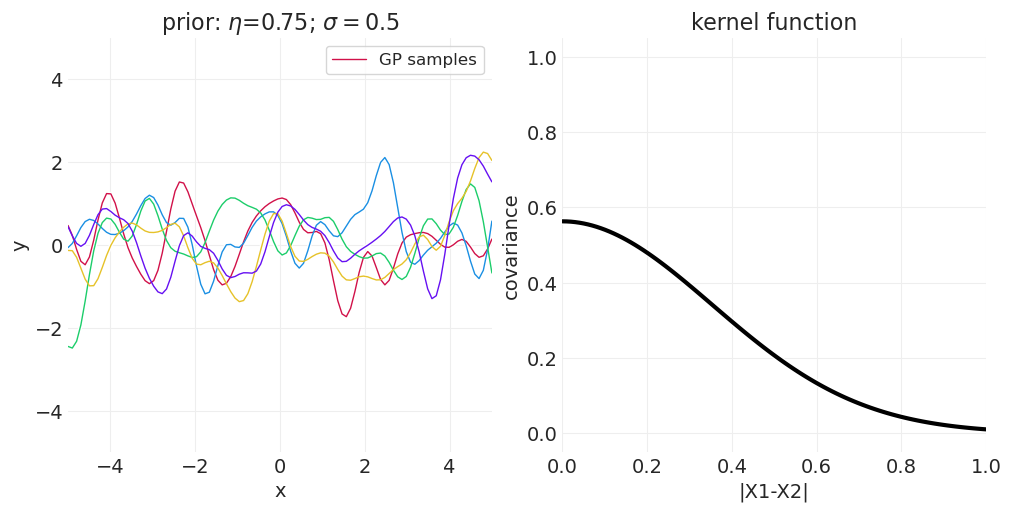

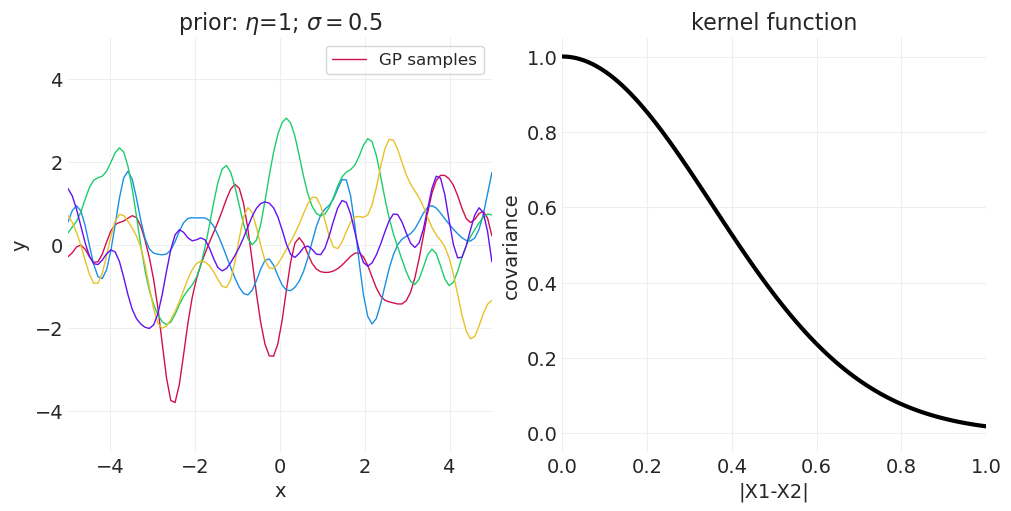

In [14]:
sigma = .5
for eta in [.25, .75, 1]:
    kernel_function = partial(quadratic_distance_kernel, eta=eta, sigma=sigma)
    axs = plot_gaussian_process_prior(kernel_function, n_samples=5)
    axs[0].set_title(f"prior: $\\eta$={eta}; $\\sigma=${sigma}")

### Gaussian Process Posterior

As the model observes data, it adjusts the posterior to account for that data while also incorporating the smoothness constraints of the prior.

In [17]:
def gaussian_process_posterior(
    X_obs: np.ndarray,
    Y_obs: np.ndarray,
    X_pred: np.ndarray,
    kernel_function,
    sigma_y: float = 1e-6,
    smoothing_factor: float = 1e-6
) -> stats._multivariate.multivariate_normal_frozen:
    """
    Computes the posterior distribution of a Gaussian Process given observations and predictions.
    
    Parameters:
    X_obs (np.ndarray): Observed input data of shape (n_obs, d).
    Y_obs (np.ndarray): Observed output data of shape (n_obs, ).
    X_pred (np.ndarray): Input data for prediction of shape (n_pred, d).
    kernel_function (callable): Kernel function that computes the covariance between points.
    sigma_y (float): Noise term for the observation covariance. Default is 1e-6.
    smoothing_factor (float): Smoothing factor added to the prediction covariance. Default is 1e-6.
    
    Returns:
    stats._multivariate.multivariate_normal_frozen: The posterior distribution of the Gaussian Process.
    """
    
    # Observation covariance matrix with noise
    K_obs = kernel_function(X_obs, X_obs) + sigma_y ** 2 * np.eye(len(X_obs))
    
    # Inverse of the observation covariance matrix
    K_obs_inv = np.linalg.inv(K_obs)

    # Covariance matrix for the prediction points with smoothing
    K_pred = kernel_function(X_pred, X_pred) + smoothing_factor * np.eye(len(X_pred))

    # Cross-covariance matrix between observations and prediction points
    K_obs_pred = kernel_function(X_obs, X_pred)

    # Compute the posterior mean
    posterior_mean = K_obs_pred.T.dot(K_obs_inv).dot(Y_obs)
    
    # Compute the posterior covariance
    posterior_cov = K_pred - K_obs_pred.T.dot(K_obs_inv).dot(K_obs_pred)
    
    # Return the posterior distribution as a multivariate normal distribution
    return stats.multivariate_normal(mean=posterior_mean.ravel(), cov=posterior_cov, allow_singular=True)

In [18]:
def plot_gaussian_process_posterior(
    X_obs: np.ndarray,
    Y_obs: np.ndarray,
    X_pred: np.ndarray,
    kernel_function,
    sigma_y: float = 1e-6,
    n_samples: int = 3,
    figsize: tuple = (10, 5),
    resolution: int = 100
):
    """
    Plots the posterior of a Gaussian Process given observations and prediction points.
    
    Parameters:
    X_obs (np.ndarray): Observed input data of shape (n_obs, d).
    Y_obs (np.ndarray): Observed output data of shape (n_obs, ).
    X_pred (np.ndarray): Input data for prediction of shape (n_pred, d).
    kernel_function (callable): Kernel function that computes the covariance between points.
    sigma_y (float): Noise term for the observation covariance. Default is 1e-6.
    n_samples (int): Number of samples to draw from the posterior. Default is 3.
    figsize (tuple): Size of the figure for plotting. Default is (10, 5).
    resolution (int): Resolution for the prediction grid. Default is 100.
    
    Returns:
    axs (np.ndarray): Array of matplotlib Axes objects.
    """
    
    # Create a prediction grid
    X = np.linspace(-5, 5, resolution)[:, None]
    
    # Compute the Gaussian Process posterior
    posterior = gaussian_process_posterior(X_obs, Y_obs, X, kernel_function, sigma_y=sigma_y)
    
    # Sample from the posterior
    samples = posterior.rvs(n_samples)

    # Set up the subplots
    fig, axs = plt.subplots(1, 2, figsize=figsize)
    
    # Plot the Gaussian Process samples and the posterior distribution
    plt.sca(axs[0])
    plot_gaussian_process(
        X,
        samples=samples,
        mean=posterior.mean,
        cov=posterior.cov,
        X_obs=X_obs,
        Y_obs=Y_obs
    )
    
    # Plot the kernel function
    plt.sca(axs[1])
    plot_kernel_function(kernel_function, color='k')
    plt.title("Kernel Function")
    
    return axs

Text(0.5, 1.0, 'kernel function:\n$\\eta$=1; $\\sigma=$0.5')

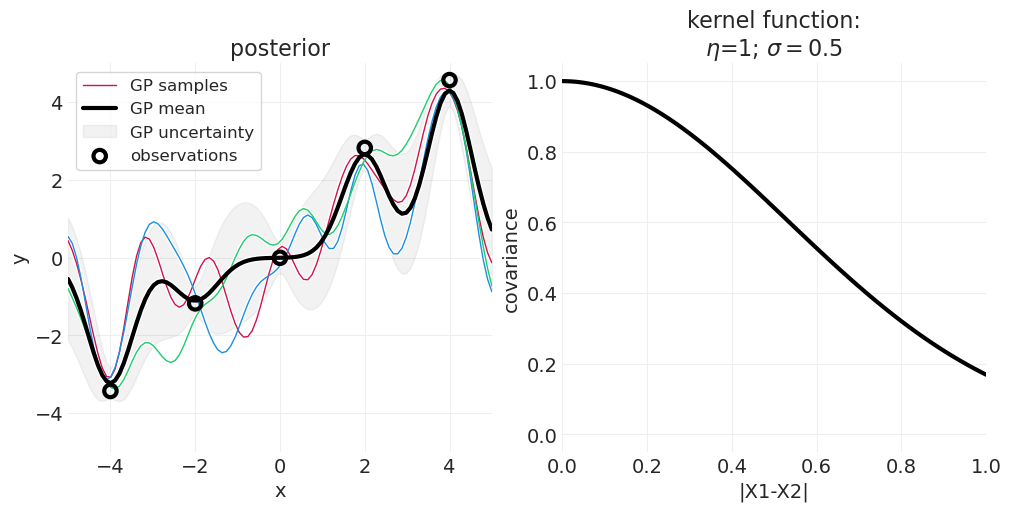

In [23]:
# Generate some training data
X_pred = np.linspace(-5, 5, 100)[:, None]
X_obs = np.linspace(-4, 4, 5)[:, None]
Y_obs = np.sin(X_obs) ** 2 + X_obs

# Initialize the kernel function
sigma_y = .25
sigma_kernel = .75
eta_kernel = 1
kernel_function = partial(quadratic_distance_kernel, eta=eta_kernel, sigma=sigma_kernel)

# Plot posterior
axs = plot_gaussian_process_posterior(X_obs, Y_obs, X_pred, kernel_function, sigma_y=sigma_y, n_samples=3)
axs[0].set_title(f"posterior");
axs[1].set_title(f"kernel function:\n$\\eta$={eta}; $\\sigma=${sigma}")

## Distance-based model

$$
\begin{align}
T_i &\sim \text{Poisson}(\lambda_i) \\
\log(\lambda_i) &= \bar \alpha + \alpha_{S[i]} \\
\begin{pmatrix}
\alpha_1 \\
\alpha_2 \\
\vdots \\
\alpha_{10}
\end{pmatrix} &= \text{MVNormal}\left( 
\begin{bmatrix}
0 \\
0 \\
\vdots \\
0
\end{bmatrix}, \textbf{K}
\right) \\
k_{i,j} &= \eta^2\exp(-\rho^2D_{i,j}^2)) \\
\eta^2 &\sim \text{Exponential}(2) \\
\rho^2 &\sim \text{Exponential}(0.5)
\end{align}
$$

### Islands Distance Matrix

In [13]:
# Distance matrix D_{i, j}
ISLANDS_DISTANCE_MATRIX = utils.load_data('islands_distance_matrix')
ISLANDS_DISTANCE_MATRIX.set_index(ISLANDS_DISTANCE_MATRIX.columns, inplace=True)
ISLANDS_DISTANCE_MATRIX.style.format(precision=1).background_gradient(cmap='viridis').set_caption("Distance in Thousands of km")

,Malekula,Tikopia,Santa Cruz,Yap,Lau Fiji,Trobriand,Chuuk,Manus,Tonga,Hawaii
Malekula,0.0,0.5,0.6,4.4,1.2,2.0,3.2,2.8,1.9,5.7
Tikopia,0.5,0.0,0.3,4.2,1.2,2.0,2.9,2.7,2.0,5.3
Santa Cruz,0.6,0.3,0.0,3.9,1.6,1.7,2.6,2.4,2.3,5.4
Yap,4.4,4.2,3.9,0.0,5.4,2.5,1.6,1.6,6.1,7.2
Lau Fiji,1.2,1.2,1.6,5.4,0.0,3.2,4.0,3.9,0.8,4.9
Trobriand,2.0,2.0,1.7,2.5,3.2,0.0,1.8,0.8,3.9,6.7
Chuuk,3.2,2.9,2.6,1.6,4.0,1.8,0.0,1.2,4.8,5.8
Manus,2.8,2.7,2.4,1.6,3.9,0.8,1.2,0.0,4.6,6.7
Tonga,1.9,2.0,2.3,6.1,0.8,3.9,4.8,4.6,0.0,5.0
Hawaii,5.7,5.3,5.4,7.2,4.9,6.7,5.8,6.7,5.0,0.0


In [14]:
# Data / coords
CULTURE_ID, CULTURE = pd.factorize(KLINE.culture.values)
ISLAND_DISTANCES = ISLANDS_DISTANCE_MATRIX.values.astype(float)
TOOLS = KLINE.total_tools.values.astype(int)
coords = {"culture": CULTURE}

with pm.Model(coords=coords) as distance_model:
        
    # Priors
    alpha_bar = pm.Normal("alpha_bar", 3, 0.5)
    eta_squared = pm.Exponential("eta_squared", 2)
    rho_squared = pm.Exponential("rho_squared", 0.5)
    
    # Gaussian Process
    kernel_function = eta_squared * pm.gp.cov.ExpQuad(input_dim=1, ls=rho_squared)
    GP = pm.gp.Latent(cov_func=kernel_function)
    alpha = GP.prior("alpha", X=ISLAND_DISTANCES, dims="culture")
    
    # Likelihood
    lambda_T = pm.math.exp(alpha_bar + alpha[CULTURE_ID])
    pm.Poisson("T", lambda_T, dims='culture', observed=TOOLS)

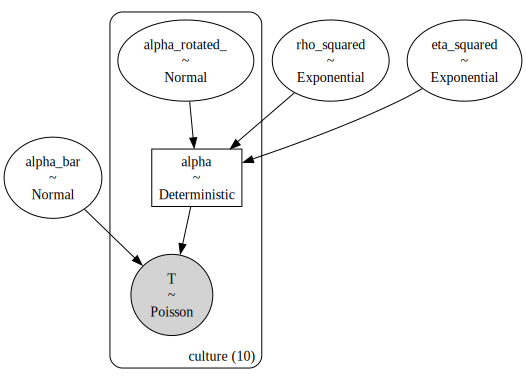

In [15]:
pm.model_to_graphviz(distance_model)

### Check model with prior-predictive simulation

In [16]:
def plot_predictive_covariance(predictive, n_samples=30, color='C0', label=None):

    eta_samples = predictive['eta_squared'].values[0, :n_samples] ** .5
    sigma_samples = 1 / predictive['rho_squared'].values[0, :n_samples] ** .5
    
    for ii, (eta, sigma) in enumerate(zip(eta_samples, sigma_samples)):
        label = label if ii == 0 else None

        kernel_function = partial(quadratic_distance_kernel, eta=eta, sigma=sigma)
        plot_kernel_function(kernel_function, color=color, label=label, alpha=.5, linewidth=5, max_distance=7)

Sampling: [T, alpha_bar, alpha_rotated_, eta_squared, rho_squared]


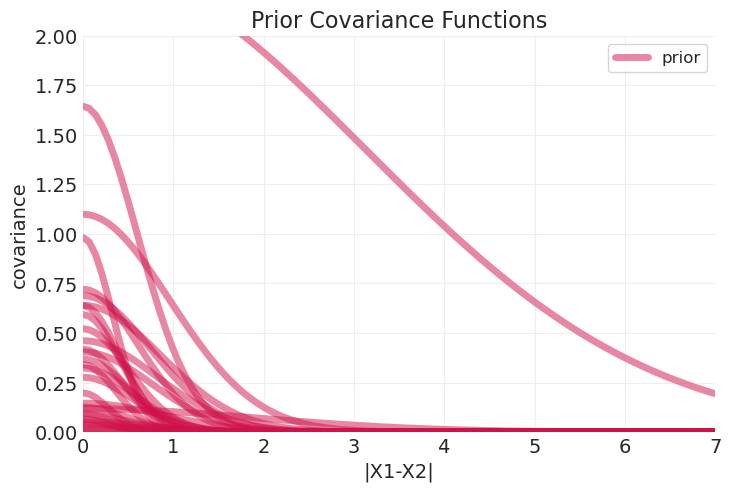

In [17]:
with distance_model:
    prior_predictive = pm.sample_prior_predictive(random_seed=12).prior

plot_predictive_covariance(prior_predictive, label='prior')
plt.ylim([0, 2]);
plt.title("Prior Covariance Functions");

### Model the data

In [18]:
with distance_model:
    distance_inference = pm.sample(target_accept=.99)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha_bar, eta_squared, rho_squared, alpha_rotated_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [19]:
az.summary(distance_inference, var_names=["~alpha_rotated_"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha_bar,3.375,0.218,2.932,3.763,0.007,0.005,881.0,1313.0,1.00
eta_squared,0.393,0.250,0.078,0.815,0.008,0.006,760.0,1866.0,1.00
rho_squared,0.242,0.408,0.000,0.647,0.031,0.022,329.0,166.0,1.01
alpha[Malekula],-0.667,0.305,-1.237,-0.111,0.009,0.006,1281.0,1618.0,1.00
alpha[Tikopia],-0.279,0.280,-0.808,0.254,0.008,0.005,1360.0,1796.0,1.00
alpha[Santa Cruz],-0.194,0.271,-0.720,0.305,0.007,0.005,1410.0,1916.0,1.00
alpha[Yap],0.353,0.258,-0.101,0.875,0.008,0.006,1022.0,1778.0,1.00
alpha[Lau Fiji],0.108,0.261,-0.369,0.605,0.008,0.006,1142.0,1552.0,1.00
alpha[Trobriand],-0.265,0.315,-0.820,0.352,0.012,0.008,807.0,655.0,1.00
alpha[Chuuk],0.272,0.257,-0.215,0.756,0.008,0.005,1139.0,1731.0,1.00


### Posterior Predictions

#### Compare the Prior to the Posterior

Ensure that we've learned something

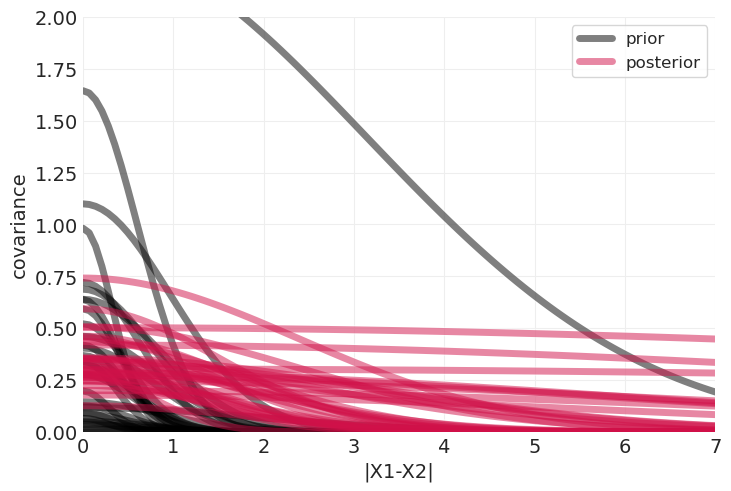

In [20]:
plot_predictive_covariance(prior_predictive, color='k', label='prior')
plot_predictive_covariance(distance_inference.posterior, label='posterior')
plt.ylim([0, 2]);

In [21]:
def distance_to_covariance(distance, eta_squared, rho_squared):
    return eta_squared * np.exp(-rho_squared * distance ** 2)


def calculate_posterior_mean_covariance_matrix(inference):
    posterior_mean = inference.posterior.mean(dim=('chain', 'draw'))
    
    posterior_eta_squared = posterior_mean['eta_squared'].values
    posterior_rho_squared = posterior_mean['rho_squared'].values

    print("Posterior Mean Kernel parameters:")
    print("eta_squared:", posterior_eta_squared)
    print("rho_squared:", posterior_rho_squared)
    
    model_covariance = np.zeros_like(ISLANDS_DISTANCE_MATRIX).astype(float)
    for ii in range(10):
        for jj in range(10):
            model_covariance[ii, jj] = distance_to_covariance(
                ISLAND_DISTANCES[ii, jj],
                eta_squared=posterior_eta_squared,
                rho_squared=posterior_rho_squared
            )
                
    return model_covariance

def plot_posterior_mean_covariance_matrix(covariance_matrix, clim=(0, .4)):
    plt.matshow(covariance_matrix)
    plt.xticks(np.arange(10), labels=KLINE.culture, rotation=90)
    plt.yticks(np.arange(10), labels=KLINE.culture)
    plt.clim(clim)
    plt.grid(False)
    plt.colorbar()
    plt.title("posterior mean covariance matrix");


Posterior Mean Kernel parameters:
eta_squared: 0.3931467156875348
rho_squared: 0.24226382423140339


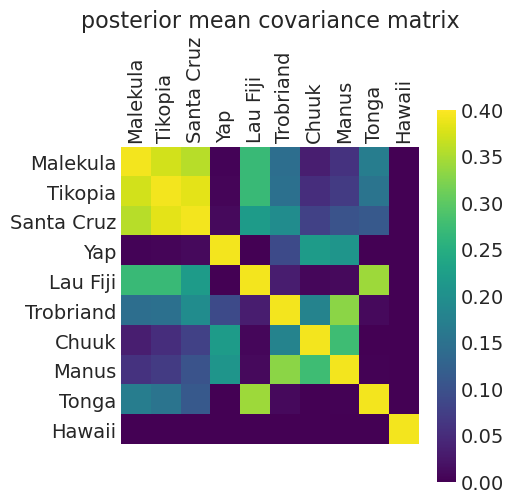

In [22]:
distance_model_covariance = calculate_posterior_mean_covariance_matrix(distance_inference)
plot_posterior_mean_covariance_matrix(distance_model_covariance)

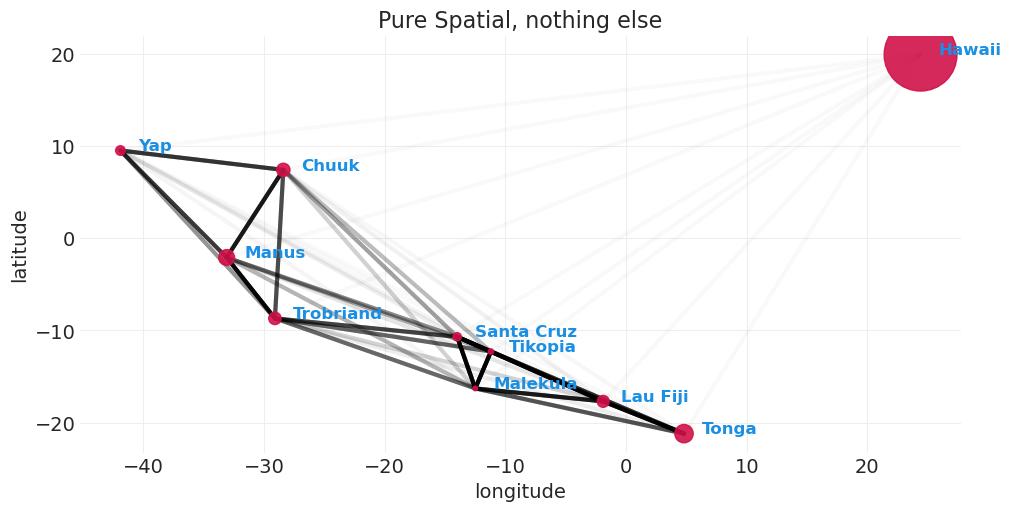

In [23]:
def plot_kline_model_covarance(covariance_matric, min_alpha=.01, alpha_gain=1, max_cov=None):
    plt.subplots(figsize=(10, 5))
    # Plot covariance
    max_cov = covariance_matric.max() if max_cov is None else max_cov
    for ii in range(10):
        for jj in range(10):
            if ii != jj:
                lat_a = KLINE.loc[ii, 'lat']
                lon_a = KLINE.loc[ii, 'lon2']

                lat_b = KLINE.loc[jj, 'lat']
                lon_b = KLINE.loc[jj, 'lon2']
                cov = covariance_matric[ii, jj]
                alpha = (min_alpha + (1 - min_alpha) * (cov / max_cov)) ** (1 / alpha_gain)
                plt.plot((lon_a, lon_b), (lat_a, lat_b), linewidth=3, color='k', alpha=alpha)

    plt.scatter(KLINE.lon2, KLINE.lat, s=KLINE.population * .01, zorder=10, alpha=.9)

    # Annotate
    for ii in range(10):
        plt.annotate(
            KLINE.loc[ii, 'culture'],
            (KLINE.loc[ii, 'lon2'] + 1.5, KLINE.loc[ii, 'lat']),
            zorder=11,
            color='C1',
            fontsize=12,
            fontweight='bold'
        )
    plt.xlabel("longitude")
    plt.ylabel("latitude");
    plt.axis('tight')

plot_kline_model_covarance(distance_model_covariance, max_cov=.4)
plt.title("Pure Spatial, nothing else");

## Stratify by population size

$$
\begin{align}
T_i &\sim \text{Poisson}(\lambda_i) \\
\lambda_i &= \frac{\bar \alpha P^\beta}{\gamma} \exp(\alpha_{S[i]}) \\
    \begin{pmatrix}
        \alpha_1 \\
        \alpha_2 \\
        \vdots \\
        \alpha_{10}
    \end{pmatrix} &= \text{MVNormal}
    \left( 
        \begin{bmatrix}
            0 \\
            0 \\
            \vdots \\
            0
        \end{bmatrix}, \textbf{K}
    \right) \\
    k_{i,j} &= \eta^2\exp(-\rho^2D_{i,j}^2)) \\
    \bar \alpha, \beta, \gamma &\sim \text{Exponential}(1) \\
    \eta^2 &\sim \text{Exponential}(2) \\
    \rho^2 &\sim \text{Exponential}(0.5)
\end{align}
$$

- We now fold our steady state equation into the intercept/baseline tools equation
- Include an additional $\exp$ multiplier to handle society-level offsets. Idea here being that
  - if $\alpha_{S[i]}=0$, then the society is average, and we fall back to the expected value of the difference equation i.e. multiplier is one
  - if $\alpha_{S[i]}>0$ then there is a boost in tool production. This boost is shared amongst spatially-local societies


In [24]:
with pm.Model(coords=coords) as distance_population_model:
    
    population = pm.MutableData('log_population', KLINE.logpop.values.astype(float))
    CULTURE_ID_ = pm.MutableData("CULTURE_ID", CULTURE_ID)
        
    # Priors
    alpha_bar = pm.Exponential("alpha_bar", 1)
    gamma = pm.Exponential("gamma", 1)
    beta = pm.Exponential("beta", 1)
    eta_squared = pm.Exponential("eta_squared", 2)
    rho_squared = pm.Exponential("rho_squared", 2)
    
    # Gaussian Process
    kernel_function = eta_squared * pm.gp.cov.ExpQuad(input_dim=1, ls=rho_squared)
    GP = pm.gp.Latent(cov_func=kernel_function)
    alpha = GP.prior("alpha", X=ISLAND_DISTANCES, dims="culture")
    
    # Likelihood
    lambda_T = (alpha_bar / gamma * population[CULTURE_ID_] ** beta) * pm.math.exp(alpha[CULTURE_ID_])
    pm.Poisson("T", lambda_T, observed=TOOLS, dims='culture')

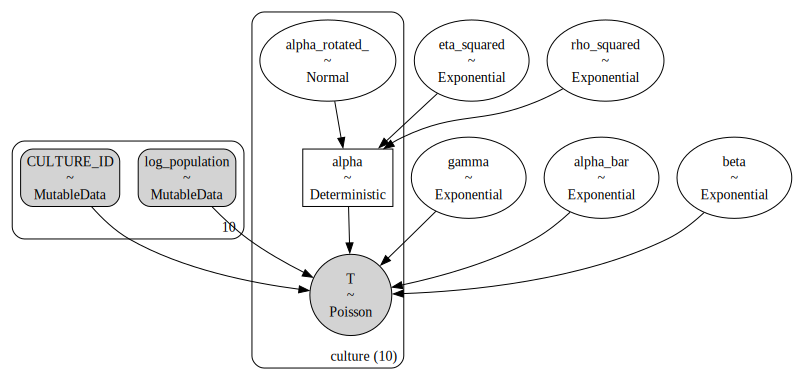

In [25]:
pm.model_to_graphviz(distance_population_model)

### Prior Predictive

Sampling: [T, alpha_bar, alpha_rotated_, beta, eta_squared, gamma, rho_squared]


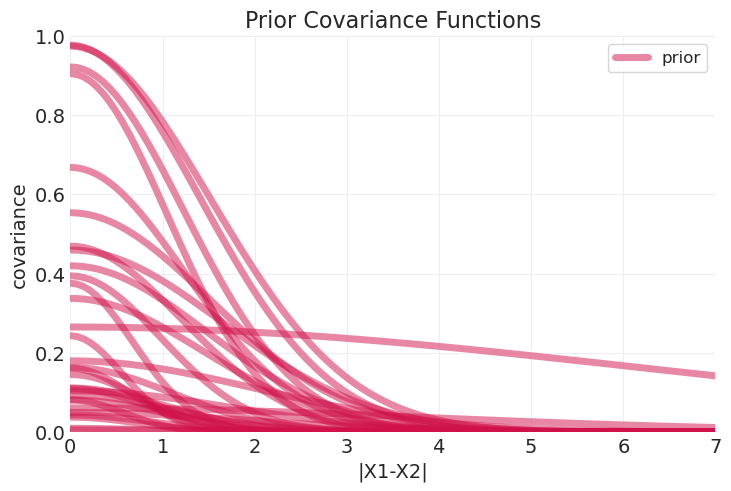

In [26]:
with distance_population_model:
    prior_predictive = pm.sample_prior_predictive(random_seed=12).prior

plot_predictive_covariance(prior_predictive, label='prior')
plt.ylim([0, 1]);
plt.title("Prior Covariance Functions");

In [27]:
with distance_population_model:
    distance_population_inference = pm.sample(target_accept=.99)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha_bar, gamma, beta, eta_squared, rho_squared, alpha_rotated_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 91 seconds.


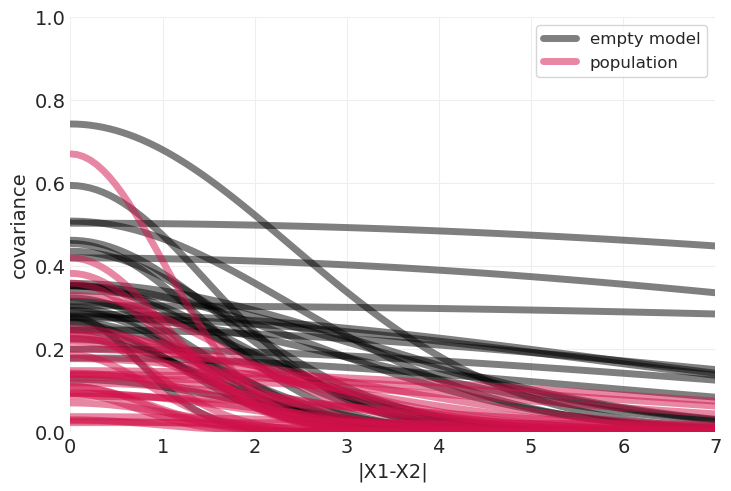

In [28]:
plot_predictive_covariance(distance_inference.posterior, color='k', label='empty model')
plot_predictive_covariance(distance_population_inference.posterior, label='population')
plt.ylim([0, 1]);

Posterior Mean Kernel parameters:
eta_squared: 0.15527850546673727
rho_squared: 0.19624731523995942


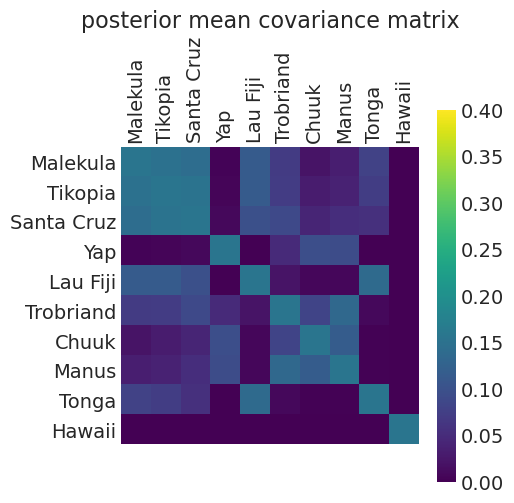

In [29]:
distance_population_model_covariance = calculate_posterior_mean_covariance_matrix(distance_population_inference)
plot_posterior_mean_covariance_matrix(distance_population_model_covariance)

We can see that by including population, the degree of covariance required to explain tool use is diminished, compared to the distance-only model. i.e. population has explained away a lot more of the variation.

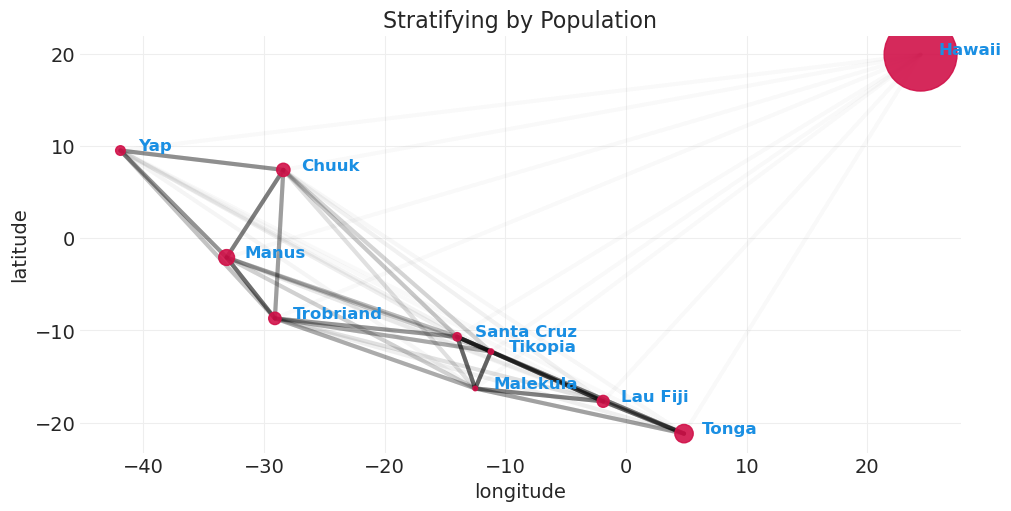

In [30]:
plot_kline_model_covarance(distance_population_model_covariance, max_cov=.4)
plt.title("Stratifying by Population");

#### Fit population-only model for comparison
I _think_ this is what McElreath is doing to construct the plot that combines population size, tool use and island covariance (next plot below). Specifically, we estimate a population-only model using the analytical solution, but includes no covariance amongst islands. We then compare add the covariance plot on top of that model to demonstrate that there is still some information left on the table regarding covariances, even when including population in the model.

In [31]:
ETA = 5.1  # Exponential hyperparmeter taken from Lecture 10 notes
with pm.Model() as population_model:
    
    # Note: raw population here, not log/standardized
    population = pm.MutableData("population", KLINE.logpop.values)
    
    # Priors
    # innovation rate
    alpha = pm.Exponential("alpha", eta)
    
    # Contact-level elasticity
    beta = pm.Exponential("beta", eta)
    
    # G lobal technology loss rate
    gamma = pm.Exponential("gamma", eta)
    
    # Likelihood using difference equation equilibrium as mean Poisson rate
    lamb = (alpha * (population ** beta)) / gamma
    pm.Poisson("tools", lamb, observed=TOOLS)

    population_inference = pm.sample(tune=2000, target_accept=.98)
    population_inference = pm.sample_posterior_predictive(population_inference, extend_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, gamma]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 15 seconds.
Sampling: [tools]


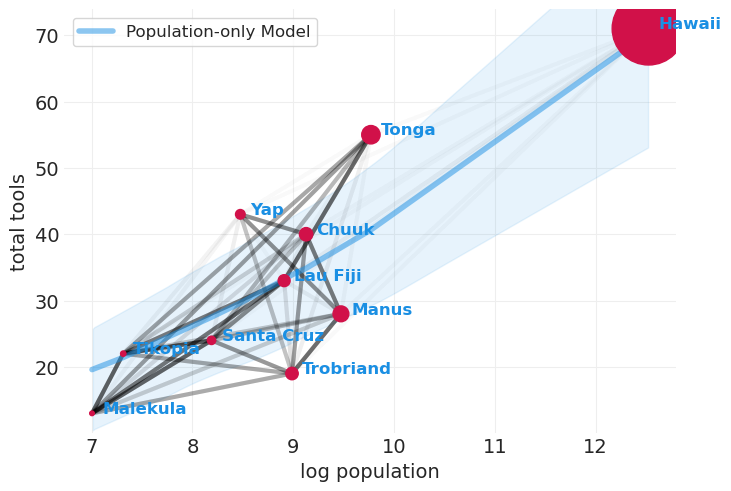

In [32]:
def plot_kline_model_population_covariance(covariance_matric, min_alpha=.01, alpha_gain=1, max_cov=None):

    # Plot covariancef
    max_cov = covariance_matric.max() if max_cov is None else max_cov
    for ii in range(10):
        for jj in range(10):
            if ii != jj:
                logpop_a = KLINE.loc[ii, 'logpop']
                tools_a = KLINE.loc[ii, 'total_tools']

                logpop_b = KLINE.loc[jj, 'logpop']
                tools_b = KLINE.loc[jj, 'total_tools']
                cov = covariance_matric[ii, jj]
                alpha = (min_alpha + (1 - min_alpha) * (cov / max_cov)) ** (1 / alpha_gain)
                plt.plot((logpop_a, logpop_b), (tools_a, tools_b), linewidth=3, color='k', alpha=alpha)

    plt.scatter(KLINE.logpop, KLINE.total_tools, s=KLINE.population * .01, zorder=10)

    # Annotate
    for ii in range(10):
        plt.annotate(
            KLINE.loc[ii, 'culture'],
            (KLINE.loc[ii, 'logpop'] + .1, KLINE.loc[ii, 'total_tools']),
            zorder=11,
            color='C1',
            fontsize=12,
            fontweight='bold'
        )
    plt.xlabel("log population")
    plt.ylabel("total tools")
    plt.axis('tight');
    

def plot_kline_population_only_model_posterior_predictive(inference):
    ppd = inference.posterior_predictive['tools']
    az.plot_hdi(
        x=KLINE.logpop,
        y=ppd, color="C1",
        hdi_prob=.89,
        fill_kwargs={"alpha": 0.1},
    )

    plt.plot(
        KLINE.logpop,
        ppd.mean(dim=('chain', 'draw')),
        color='C1', linewidth=4, alpha=.5,
        label='Population-only Model'
    )
    plt.legend()

plot_kline_model_population_covariance(distance_population_model_covariance, max_cov=0.4)
plot_kline_population_only_model_posterior_predictive(population_inference)

Though Population alone accounts for a lot of the variance in tool use (blue curve), there's still quite a bit of residual island-island similarity that explains tool use (i.e. some of the black lines still have some weight).

# Phylogenetic Regression
## Dataset: Primates301

In [33]:
PRIMATES301 = utils.load_data("Primates301")
PRIMATES301.head()

,name,genus,species,subspecies,spp_id,genus_id,social_learning,research_effort,brain,body,group_size,gestation,weaning,longevity,sex_maturity,maternal_investment
0,Allenopithecus_nigroviridis,Allenopithecus,nigroviridis,NaN,1,1,0.0,6.0,58.02,4655.00,40.0,NaN,106.15,276.0,NaN,NaN
1,Allocebus_trichotis,Allocebus,trichotis,NaN,2,2,0.0,6.0,NaN,78.09,1.0,NaN,NaN,NaN,NaN,NaN
2,Alouatta_belzebul,Alouatta,belzebul,NaN,3,3,0.0,15.0,52.84,6395.00,7.4,NaN,NaN,NaN,NaN,NaN
3,Alouatta_caraya,Alouatta,caraya,NaN,4,3,0.0,45.0,52.63,5383.00,8.9,185.92,323.16,243.6,1276.72,509.08
4,Alouatta_guariba,Alouatta,guariba,NaN,5,3,0.0,37.0,51.70,5175.00,7.4,NaN,NaN,NaN,NaN,NaN


- 301 Primate species
- Life history traits
- Body Mass $M$, Brain Size $B$, Social Group Size $G$
- Measurement error, unobserved confounding
- Missing data, **we'll fucus on the complete case analysis** in this lecture

#### Filter out 151 **Complete Cases**
Drop osbservations missing either Body Mass, Brain Size, or Group size

In [34]:
PRIMATES = PRIMATES301.query(
    "brain.notnull() and body.notnull() and group_size.notnull()",
    engine='python'
)
PRIMATES

,name,genus,species,subspecies,spp_id,genus_id,social_learning,research_effort,brain,body,group_size,gestation,weaning,longevity,sex_maturity,maternal_investment
0,Allenopithecus_nigroviridis,Allenopithecus,nigroviridis,NaN,1,1,0.0,6.0,58.02,4655.0,40.00,NaN,106.15,276.0,NaN,NaN
2,Alouatta_belzebul,Alouatta,belzebul,NaN,3,3,0.0,15.0,52.84,6395.0,7.40,NaN,NaN,NaN,NaN,NaN
3,Alouatta_caraya,Alouatta,caraya,NaN,4,3,0.0,45.0,52.63,5383.0,8.90,185.92,323.16,243.6,1276.72,509.08
4,Alouatta_guariba,Alouatta,guariba,NaN,5,3,0.0,37.0,51.70,5175.0,7.40,NaN,NaN,NaN,NaN,NaN
5,Alouatta_palliata,Alouatta,palliata,NaN,6,3,3.0,79.0,49.88,6250.0,13.10,185.42,495.60,300.0,1578.42,681.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,Trachypithecus_obscurus,Trachypithecus,obscurus,NaN,295,67,0.0,6.0,62.12,7056.0,10.00,146.63,362.93,300.0,NaN,509.56
295,Trachypithecus_phayrei,Trachypithecus,phayrei,NaN,296,67,0.0,16.0,72.84,7475.0,12.90,180.61,305.87,NaN,NaN,486.48
296,Trachypithecus_pileatus,Trachypithecus,pileatus,NaN,297,67,0.0,5.0,103.64,11794.0,8.50,NaN,NaN,NaN,NaN,NaN
298,Trachypithecus_vetulus,Trachypithecus,vetulus,NaN,299,67,0.0,2.0,61.29,6237.0,8.35,204.72,245.78,276.0,1113.70,450.50


#### There's lot's of Covariation amongst variables

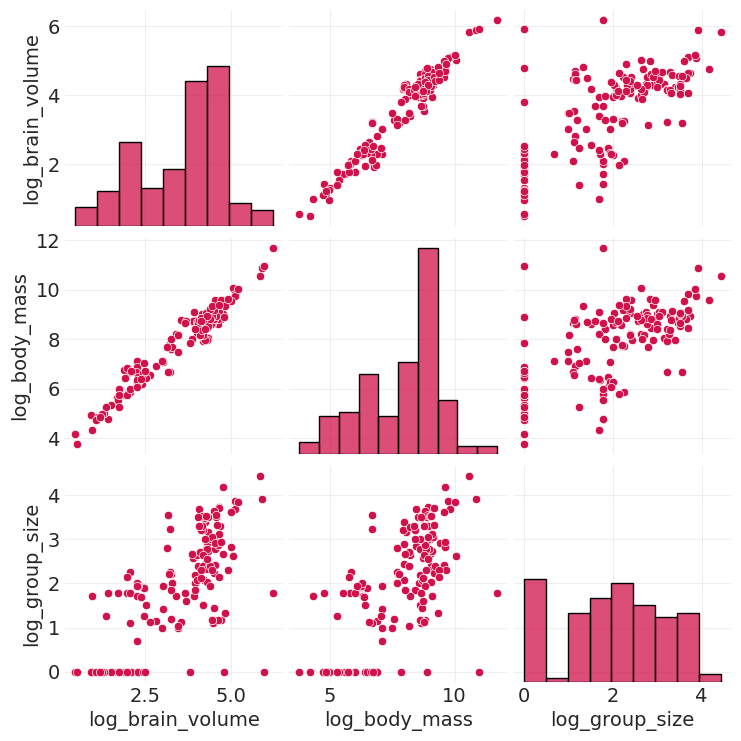

In [35]:
from seaborn import pairplot
pairplot(
    PRIMATES.assign(
        log_brain_volume=lambda x: np.log(x['brain']),
        log_body_mass=lambda x: np.log(x['body']),
        log_group_size=lambda x: np.log(x['group_size']),
    )[['log_brain_volume', 'log_body_mass', 'log_group_size']]
);

There's no way from the sample alone to know what causes what

## Causal Salad
- Throwing all predictors into a model, then interpreting their coefficients causally
- Using prediction methods as a stand-in for causality
- Throwing all factors into "salad" of regression terms
    - performing model selection base on prediction (we showed earlier in [Lecture 07 - Fitting Over & Under](<Lecture 07 - Fitting Over & Under.ipynb>) why this is bad to do)
    - and interpreting the resulting coefficients as causal effects (we've shown why this is bad many times)
- Controlling for phylogeny is important to do, but it's often done mindlessly (with the "salad" approach)
- Regression with phylogeny still requires a causal model

## Different Hypotheses required different causal models (DAGs)

### Social Brain Hypothesis
- Group Size $G$ Effects Brain Size $B$

#### Body Mass $M$ is a shared cause  for both $M$ and $B$
This is the DAG we'll focus on in this Lecture

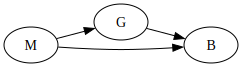

In [36]:
utils.draw_causal_graph(
    edge_list=[
        ("G", "B"),
        ("M", "G"),
        ("M", "B")
    ],
    graph_direction="LR"
)

#### Body Mass $M$ is a mediator for both $M$ and $B$

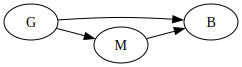

In [37]:
utils.draw_causal_graph(
    edge_list=[
        ("G", "B"),
        ("G", "M"),
        ("M", "B")
    ],
    graph_direction="LR"
)

#### Brain Size $B$ actually causes Group Size $G$; $M$ still a shared cause of both

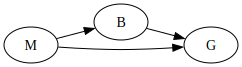

In [38]:
utils.draw_causal_graph(
    edge_list=[
        ("B", "G"),
        ("M", "G"),
        ("M", "B")
    ],
    graph_direction="LR"
)

#### Unobserved confounds make naive regression on traits w/out controlling for history is dangerous
- History induces a number of unobserved shared confounds that we need to try to control for.
- phylogenetic history can work as a proxy for these shared confounds.
- We only have current measurements of outcome of history
  - actual phylogenies do not exist
  - different parts of a genome can have different histories


BUT, say that we _do_ have an inferred phylogeny (as we do in this lecture), we use this phylogeny, in conjunction with Gaussian Process Regression to model the similarity amongst species as a proxy for shared history

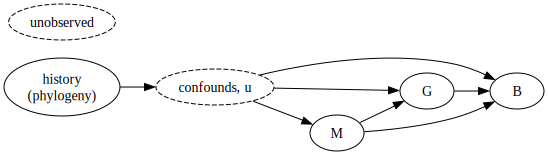

In [39]:
utils.draw_causal_graph(
    edge_list=[
        ("G", "B"),
        ("M", "G"),
        ("M", "B"),
        ("u", "M"),
        ("u", "G"),
        ("u", "B"),
        ("h", "u")
    ],
    node_props={
        "h": {"label": "history\n(phylogeny)"},
        "u": {"style": "dashed", "label": "confounds, u"},
        "unobserved": {"style": "dashed"},
        
    },
    
    graph_direction="LR"
)

## Phylogenetic Regression
- There's a long history of genetic evolution
- We only get to measure the current end state of that process
- In principle, common genetic histories should induce covariation amongst species
- We should hopefully be able to model this covariation to average over all the possible histories (micro state) that could have led to genetic similarity (macro state)

### Two conjoint problems

1. What is the history (phylogeny)?
2. How do we use it to model causes and control for confounds?


#### 1. What is the history (phylogeny)?

How do we estimate or identify a phylogeny?

##### Difficulties
- high degree of uncertainty
- processes are non-stationary
  - different parts of the genome have different histories
  - crossing-over effects
- available inferential tools
  - exploring tree space is difficult
  - repurposing software from other domains for studying biology
- phylogenies (just like social networks) do not exist.
  - They are abstractions we use to capture regularities in data
 
#### 2. How do we use it to model causes?

...say we've obtained a phylogeny, now what?


##### Approaches
- no default approach
- Gaussian Processes are default approach
  - use phylogeny as proxy for "genetic distance"



## Two equivalent formulations of Linear Regression

You can always re-express a linear regression with a draw from a multi-variate Normal distribution

### Classical Linear Regression
The dataset $\textbf{B}$ is modeled as $D$ independent samples $B_i$ from a random a univariate normal.
$$
\begin{align}
B_i &\sim \text{Normal}(\mu_i, \sigma^2) \\
\mu_i &= \alpha + \beta_G G_i + \beta_M M_i \\
\alpha &\sim \text{Normal}(0, 1) \\
\beta_{G, M} &\sim \text{Normal}(0, 1) \\
\sigma &\sim \text{Exponential}(1)
\end{align}
$$

### $\text{MVNormal}$ Formulation
The dataset is modeled as a single $D$-vector $\textbf{B}$ sampled from a $\text{MVNormal}$. Has more of a Gaussian-process flavor to it; allows us to formulate the Linear regressoin in order to include covariation amongst the outputs.

$$
\begin{align}
\textbf{B} &\sim \text{MVNormal}(\mu, \textbf{K}) \\
\mathbf{K} &= \mathbf{I}\sigma^2 \\
\mu_i &= \alpha + \beta_G G_i + \beta_M M_i \\
\alpha &\sim \text{Normal}(0, 1) \\
\beta_{G, M} &\sim \text{Normal}(0, 1) \\
\sigma &\sim \text{Exponential}(1)
\end{align}
$$

### Classic Linear Regression

In [40]:
# Preprocessing used in the Lecture
G = utils.standardize(np.log(PRIMATES.group_size.values))
M = utils.standardize(np.log(PRIMATES.body.values))
B = utils.standardize(np.log(PRIMATES.brain.values))

In [41]:
with pm.Model() as vanilla_lr_model:
    # Priors
    alpha = pm.Normal("alpha", 0, 1)
    beta_G = pm.Normal("beta_G", 0, .5)
    beta_M = pm.Normal("beta_M", 0, .5)
    sigma = pm.Exponential("sigma", 1)

    # Likelihood
    mu = alpha + beta_G * G + beta_M * M
    pm.Normal('B', mu=mu, sigma=sigma, observed=B)
    
    vanilla_lr_inference = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_G, beta_M, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


### $\text{MVNormal}$ Linear Regression

In [42]:
with pm.Model() as vector_lr_model:
    
    # Priors
    alpha = pm.Normal("alpha", 0, 1)
    beta_G = pm.Normal("beta_G", 0, 0.5)
    beta_M = pm.Normal("beta_M", 0, 0.5)
    sigma = pm.Exponential("sigma", 1)  
    
    # Likelihood
    K = np.eye(len(B)) * sigma ** 2
    mu = alpha + beta_G * G + beta_M * M
    pm.MvNormal('B', mu=mu, cov=K, observed=B)
    
    vector_lr_inference = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_G, beta_M, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.


#### Verify the two formulations provide the same parameter estimates
We're able to recover the same estimates as in the lecture

In [43]:
pm.summary(vanilla_lr_inference, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.00,0.02,-0.03,0.03,0.0,0.0,3901.55,3139.08,1.0
beta_G,0.12,0.02,0.08,0.17,0.0,0.0,2895.33,2988.04,1.0
beta_M,0.89,0.02,0.85,0.93,0.0,0.0,2950.04,3175.09,1.0
sigma,0.22,0.01,0.20,0.24,0.0,0.0,3665.06,3030.12,1.0


In [44]:
pm.summary(vector_lr_inference, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.00,0.02,-0.03,0.03,0.0,0.0,4296.80,3053.72,1.0
beta_G,0.12,0.02,0.08,0.17,0.0,0.0,2955.40,3226.05,1.0
beta_M,0.89,0.02,0.85,0.94,0.0,0.0,2789.40,2894.38,1.0
sigma,0.22,0.01,0.19,0.24,0.0,0.0,3908.28,2966.25,1.0


## From Model to Kernel
We'd like to **incorporate some residual $u_i$** into our linear regression that **adjusts the expecation in a way that encodes the shared history species**

$$
\begin{align}
\textbf{B} &\sim \text{MVNormal}(\mu, \textbf{K}) \\
\mathbf{K} &= \mathbf{I}\sigma^2 \\
\mu_i &= \alpha + \beta_G G_i + \beta_M M_i + u_i\\
\alpha &\sim \text{Normal}(0, 1) \\
\beta_{G, M} &\sim \text{Normal}(0, 1) \\
\sigma &\sim \text{Exponential}(1)
\end{align}
$$

### Phylogenetic distance as a proxy for species covariance
- Covariance falls off with **phylogenetic distance**
  - path length between leaf nodes in tree (e.g. see dendrogram below)
- Can use a Gaussian process in much the same way we did for island distances in the Oceanic Tools analysis

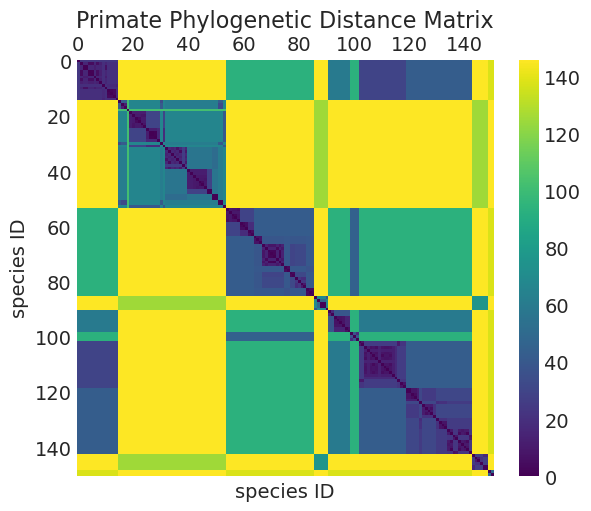

In [45]:
PRIMATES_DISTANCE_MATRIX301 = utils.load_data("primates301_distance_matrix").values
# Filter out incomplete cases
PRIMATES_DISTANCE_MATRIX = PRIMATES_DISTANCE_MATRIX301[PRIMATES.index][:, PRIMATES.index]

fig, ax = plt.subplots(figsize=(6, 5))
im = ax.matshow(PRIMATES_DISTANCE_MATRIX)
ax.grid(None)
fig.colorbar(im, orientation='vertical')
plt.xlabel('species ID')
plt.ylabel('species ID')
ax.set_title("Primate Phylogenetic Distance Matrix");

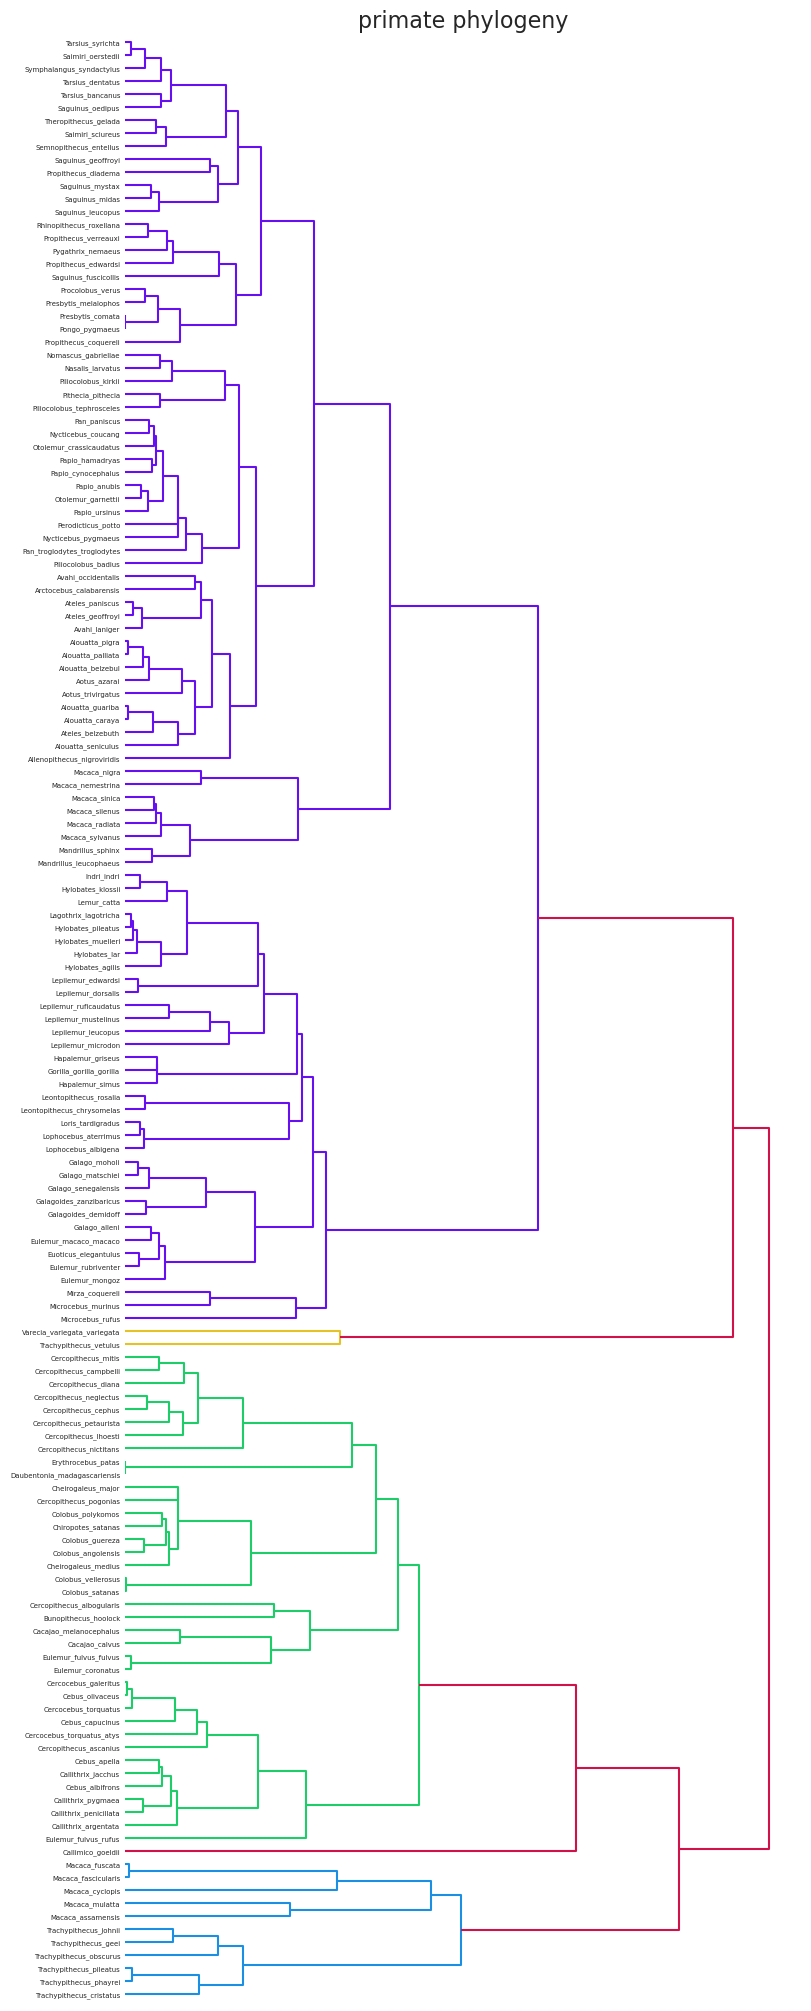

In [46]:
# Plot the distance matrix
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform

dists = squareform(PRIMATES_DISTANCE_MATRIX)
linkage_matrix = linkage(dists, "single")
plt.subplots(figsize=(8, 20))
dendrogram(
    linkage_matrix,
    orientation='right',
    distance_sort=True,
    labels=PRIMATES.name.tolist()
)
plt.title("primate phylogeny");
plt.grid(False)
plt.xticks([]);

### Kernel Function as proxy for evolutionary dynamics

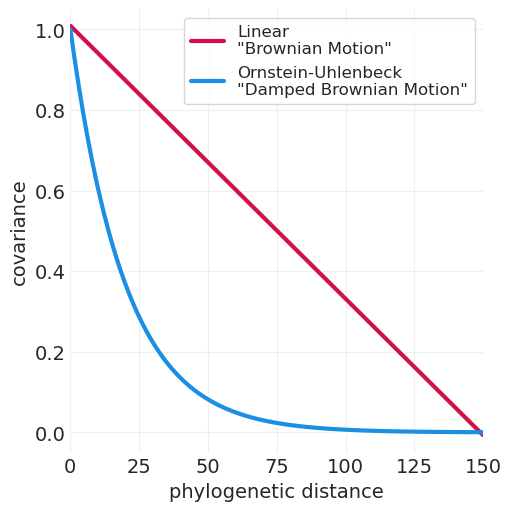

In [47]:
def brownian_motion_kernel(X0, X1, a = 1, c = 1):
    k =  1 / a * ((X0 - c) @ (X1 - c).T)[::-1, ::-1]
    return k

plt.subplots(figsize=(5, 5))
plot_kernel_function(partial(brownian_motion_kernel, a=22000), max_distance=150, label='Linear\n"Brownian Motion"')
plot_kernel_function(partial(ornstein_uhlenbeck_kernel, rho=1/20), max_distance=150, color='C1', label='Ornstein-Uhlenbeck\n"Damped Brownian Motion"')
plt.xlabel("phylogenetic distance");


#### Evolutionary model + tree structure = pattern of covariation observed at the tips

Common simple models of evolutionary dynamics:

- Brownian motion - implies in linear covariance kernel function
- Damped Brownian motion - implies an L1 / **Ornstein-Uhlenbeck** covariance kernel function

### Phylogenetic "regression" model

$$
\begin{align}
\textbf{B} &\sim \text{MVNormal}(\mu, \textbf{K}) \\
\mathbf{K} &= \eta^2 \exp(-\rho D_{ij}) &\text{Ornstein-Uhlenbeck kernel}\\
\mu_i &= \alpha + \beta_G G_i + \beta_M M_i \\
\alpha &\sim \text{Normal}(0, 1) \\
\beta_{G, M} &\sim \text{Normal}(0, 1) \\
\eta^2 &\sim \text{HalfNormal}(1, 0.25) &\text{Maximum covariance prior} \\
\rho &\sim \text{HalfNormal}(3, 0.25) &\text{Covariance decline rate prior}
\end{align}
$$

#### Prior Samples Ornstein-Uhlenbeck Kernel Model

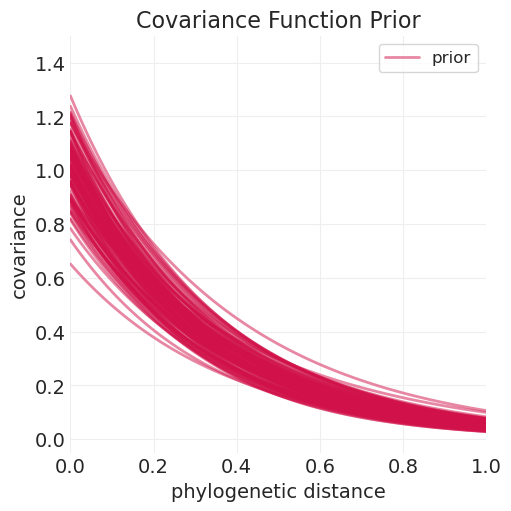

In [48]:
eta_squared_samples =  pm.draw(pm.TruncatedNormal.dist(mu=1, sigma=.25, lower=.01), 100) ** .5
rho_samples =  pm.draw(pm.TruncatedNormal.dist(mu=3, sigma=.25, lower=.01), 100)

plt.subplots(figsize=(5, 5))
for ii, (eta_squared_, rho_) in enumerate(zip(eta_squared_samples, rho_samples)):
        label = 'prior' if ii == 0 else None
        kernel_function = partial(ornstein_uhlenbeck_kernel, eta_squared=eta_squared_, rho=rho_)
        plot_kernel_function(kernel_function, color='C0', label=label, alpha=.5, linewidth=2, max_distance=1)

plt.ylim([-.05, 1.5])
plt.xlabel("phylogenetic distance")
plt.ylabel("covariance")
plt.title("Covariance Function Prior");

### Distance-only model

- Get the Gaussian-process part to work, then add details
- Set $\beta_M = \beta_G = 0$

In [49]:
# Rescale distances from 0 to 1
D = (PRIMATES_DISTANCE_MATRIX / PRIMATES_DISTANCE_MATRIX.max())
assert D.max() == 1

#### PyMC5 Implementation

Below is an implementation that uses PyMC's Gaussian process module.

- In the Oceanic Tools models above, we didn't need the Gaussian process to have a mean function because all variables were standardized, thus we can use the default mean function of $0$
- For phylogenetic regression with we no longer want a zero mean function, but we want the mean function that depends on $M$ and $G$, but not a function of the phylogenetic distance matrix. We can implement a custom mean function in pymc to handle this
- Also, because our likelihood is a MVNormal, we can take advantage of conjugacy between the GP prior and the Normal likelihood, which returns a GP posterior. This means that we should use `pm.gp.Marginal` instead of `pm.gp.Latent`, which uses closed form solutions ot the posterior to speed up learning.

In [50]:
class MeanBodyMassSocialGroupSize(pm.gp.mean.Linear):
    """Custom mean function that separates covariates from phylogeny"""
    def __init__(self, alpha, beta_G, beta_M):
        self.alpha = alpha
        self.beta_G = beta_G
        self.beta_M = beta_M

    def __call__(self, X):
        return self.alpha + self.beta_G * G + self.beta_M * M

In [51]:
PRIMATE_ID, PRIMATE = pd.factorize(PRIMATES['name'], sort=False) 
with pm.Model(coords={"primate": PRIMATE}) as intercept_only_phylogenetic_mvn_model:
    # Priors
    alpha = pm.Normal("alpha", 0, 1)
    sigma = pm.Exponential("sigma", 1)

    # Intercept-only model
    beta_M = 0
    beta_G = 0

    # Define the mean function
    mean_func = MeanBodyMassSocialGroupSize(alpha, beta_G, beta_M)

    # Phylogenetic distance covariance
    eta_squared = pm.TruncatedNormal("eta_squared", 1, .25, lower=.01)
    rho = pm.TruncatedNormal("rho", 3, .25, lower=.01)

    # For Ornstein-Uhlenbeck kernel we can use Matern 1/2 or Exponential covariance Function
    cov_func = eta_squared * pm.gp.cov.Matern12(1, ls=rho)
    # cov_func = eta_squared * pm.gp.cov.Exponential(1, ls=rho)

    # Init the GP
    gp = pm.gp.Marginal(mean_func=mean_func, cov_func=cov_func)

    # Likelihood
    gp.marginal_likelihood("B", X=D, y=B, noise=sigma)
    intercept_only_phylogenetic_mvn_inference = pm.sample(target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, sigma, eta_squared, rho]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.


Below is an alternative implementation that builds the covariance function by hand, and directly models the dataset as a `MVNormal` with mean `alpha` and covariance defined by the kernel. I find that these direct `MVNormal` implementations track better with the lecture

In [52]:
def generate_L1_kernel_matrix(D, eta_squared, rho, smoothing=0.1):
    K = eta_squared * pm.math.exp(-rho * D)
    
    # Smooth the diagonal of the covariance matrix
    N = D.shape[0]
    K += np.eye(N) * smoothing
    return K

# with pm.Model() as intercept_only_phylogenetic_mvn_model:
    
#     # Priors 
#     alpha = pm.Normal("alpha", 0, 1)

#     # Phylogenetic distance covariance
#     eta_squared = pm.TruncatedNormal("eta_squared", 1, 0.25, lower=.001)
#     rho = pm.TruncatedNormal("rho", 3, 0.25, lower=.001)

#     # Ornstein-Uhlenbeck kernel
#     K = pm.Deterministic('K', generate_L1_kernel_matrix(D, eta_squared, rho))
#     # K = pm.Deterministic('K', eta_squared * pm.math.exp(-rho * D))
    
#     # Likelihood
#     mu = pm.math.ones_like(B) * alpha
#     pm.MvNormal("B", mu=mu, cov=K, observed=B)
#     intercept_only_phylogenetic_mvn_inference = pm.sample(target_accept=.98)

In [53]:
az.summary(intercept_only_phylogenetic_mvn_inference, var_names=['alpha', 'eta_squared', 'rho'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.086,0.687,-1.216,1.406,0.010,0.010,4424.0,3365.0,1.0
eta_squared,1.073,0.236,0.647,1.520,0.004,0.003,3415.0,2132.0,1.0
rho,2.969,0.247,2.512,3.431,0.004,0.003,3914.0,2969.0,1.0


In [54]:
# Sample the prior for comparison
with intercept_only_phylogenetic_mvn_model:
    intercept_only_phylogenetic_mvn_prior = pm.sample_prior_predictive().prior
    
az.summary(intercept_only_phylogenetic_mvn_prior, var_names=["alpha", "eta_squared", "rho"])

Sampling: [B, alpha, eta_squared, rho, sigma]
arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-0.024,0.972,-1.730,1.811,0.049,0.037,393.0,426.0,NaN
eta_squared,0.994,0.264,0.467,1.452,0.012,0.008,516.0,511.0,NaN
rho,2.991,0.255,2.501,3.445,0.011,0.008,555.0,511.0,NaN


### Compare the Prior and Posterior for distance-only model

In [55]:
def calculate_mean_covariance_matrix(inference):
    def distance_to_covariance(distance, eta_squared, rho):
        return eta_squared * np.exp(-rho * np.abs(distance))
        
    inference_mean = inference.mean(dim=('chain', 'draw'))
    
    eta_squared = inference_mean['eta_squared'].values
    rho = inference_mean['rho'].values

    print("Mean Kernel parameters:")
    print("eta_squared:", eta_squared)
    print("rho:", rho)

    n_species = D.shape[0]
    model_covariance = np.zeros_like(D).astype(float)
    for ii in range(n_species):
        for jj in range(n_species):
            model_covariance[ii, jj] = distance_to_covariance(
                D[ii, jj],
                eta_squared=eta_squared,
                rho=rho
            )
    return model_covariance

def plot_mean_covariance_matrix(inference, title=None, max_cov=1.0):
    mean_cov = calculate_mean_covariance_matrix(inference)

    plt.imshow(mean_cov)
    # plt.imshow(inference['K'].mean(dim=('chain', 'draw')).values)
    plt.grid(None)
    plt.clim((0, max_cov))
    plt.colorbar();
    plt.xlabel('species ID')
    plt.ylabel('species ID')
    plt.title(title)

Mean Kernel parameters:
eta_squared: 0.9941548937182325
rho: 2.9906504330897974


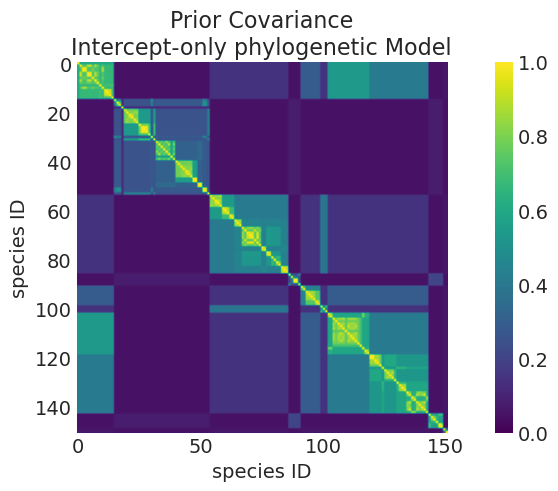

In [56]:
# Prior
plot_mean_covariance_matrix(
    intercept_only_phylogenetic_mvn_prior,
    title='Prior Covariance\nIntercept-only phylogenetic Model'
)

Mean Kernel parameters:
eta_squared: 1.0728732601832234
rho: 2.9694322677125564


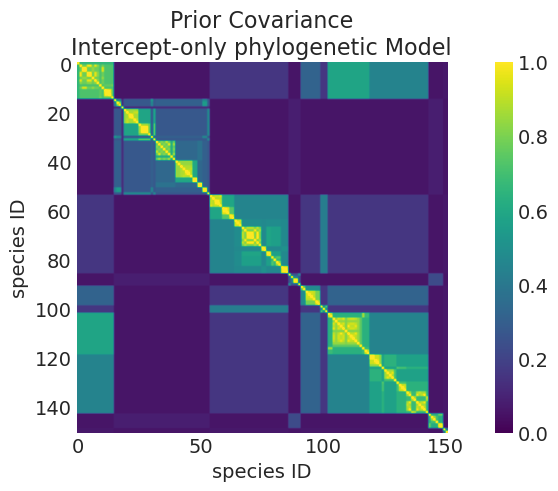

In [57]:
# Posterior
plot_mean_covariance_matrix(
    intercept_only_phylogenetic_mvn_inference.posterior,
    title='Prior Covariance\nIntercept-only phylogenetic Model'
)

#### Compare the Prior and Posterior kernel functions

In [58]:
def plot_predictive_kernel_function(predictive, n_samples=200, color='C0', label=None):

    eta_squared_samples = predictive['eta_squared'].values[0, :n_samples]
    rho_samples = predictive['rho'].values[0, :n_samples]
    
    for ii, (eta_squared_, rho_) in enumerate(zip(eta_squared_samples, rho_samples)):
        label = label if ii == 0 else None

        kernel_function = partial(ornstein_uhlenbeck_kernel, eta_squared=eta_squared_, rho=rho_)
        plot_kernel_function(kernel_function, color=color, label=label, alpha=.1, linewidth=2, max_distance=1)

    plt.ylim([-.05, 2.5]);
    plt.xlabel("phylogenetic distance")


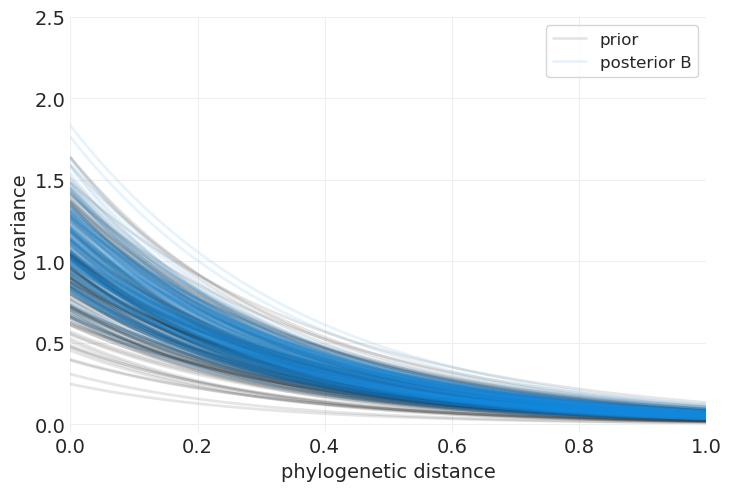

In [59]:
plot_predictive_kernel_function(intercept_only_phylogenetic_mvn_prior, label='prior', color='k')
plot_predictive_kernel_function(intercept_only_phylogenetic_mvn_inference.posterior, label='posterior B', color='C1')

We can see comparing the prior and posterior distirbution over kernel functions, that the model has learned from the data and attenuated our expectation on maximum covariance.

### Fit the full Phylogentic model.

This model stratifies by Group size $G$ and Body Mass $M$

Below is an implementation that uses PyMC's Gaussian process module.

In [60]:
with pm.Model(coords=coords) as full_phylogenetic_mvn_model:
    
    # Priors
    alpha = pm.Normal("alpha", 0, 1)
    sigma = pm.Exponential("sigma", 1)

    # Intercept-only model
    beta_M = pm.Normal("beta_M", 0, 1)
    beta_G = pm.Normal("beta_G", 0, 1)

    # Define the mean function
    mean_func = MeanBodyMassSocialGroupSize(alpha, beta_G, beta_M)

    # Phylogenetic distance covariance
    eta_squared = pm.TruncatedNormal("eta_squared", 1, .25, lower=.01)
    rho = pm.TruncatedNormal("rho", 3, .25, lower=.01)

    # For Ornstein-Uhlenbeck kernel we can use Matern 1/2 or Exponential covariance Function
    cov_func = eta_squared * pm.gp.cov.Matern12(1, ls=rho)
    # cov_func = eta_squared * pm.gp.cov.Exponential(1, ls=rho)

    # Init the GP
    gp = pm.gp.Marginal(mean_func=mean_func, cov_func=cov_func)

    # Likelihood
    gp.marginal_likelihood("B", X=D, y=B, noise=sigma)
    full_phylogenetic_mvn_inference = pm.sample(target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, sigma, beta_M, beta_G, eta_squared, rho]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 33 seconds.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.


Below is an alternative implementation that builds the covariance function by hand, and directly models the dataset as a `MVNormal` with mean being the linear function of $G$ and $M$, and covariance defined by the kernel. I find that these `MVNormal` implementations track better with the lecture.

In [61]:
# with pm.Model() as full_phylogenetic_mvn_model:
    
#     # Priors
#     alpha = pm.Normal("alpha", 0, 1)
#     beta_G = pm.Normal("beta_G", 0, 0.5)
#     beta_M = pm.Normal("beta_M", 0, 0.5)

#     # Phylogenetic distance covariance
#     eta_squared = pm.TruncatedNormal("eta_squared", 1, .25, lower=.001)
#     rho = pm.TruncatedNormal("rho", 3, .25, lower=.001)
#     K = pm.Deterministic('K', generate_L1_kernel_matrix(D, eta_squared, rho))
#     # K = pm.Deterministic('K', eta_squared * pm.math.exp(-rho * D))

#     mu = alpha + beta_G * G + beta_M * M

#     # Likelihood
#     pm.MvNormal("B", mu=mu, cov=K, observed=B)
#     full_phylogenetic_mvn_inference = pm.sample(target_accept=.98)

In [62]:
az.summary(full_phylogenetic_mvn_inference, var_names=["alpha", "eta_squared", "rho", "beta_M", "beta_G"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-0.011,0.608,-1.177,1.104,0.009,0.010,4246.0,3013.0,1.0
eta_squared,0.733,0.306,0.016,1.183,0.010,0.007,823.0,273.0,1.0
rho,3.055,0.244,2.590,3.499,0.004,0.003,3838.0,2536.0,1.0
beta_M,0.901,0.023,0.858,0.944,0.000,0.000,2923.0,2880.0,1.0
beta_G,0.108,0.025,0.060,0.154,0.000,0.000,3355.0,2809.0,1.0


### Compare covariance terms in distance-only and full phylogenetic regression models

Mean Kernel parameters:
eta_squared: 0.732965901140283
rho: 3.055235825579112


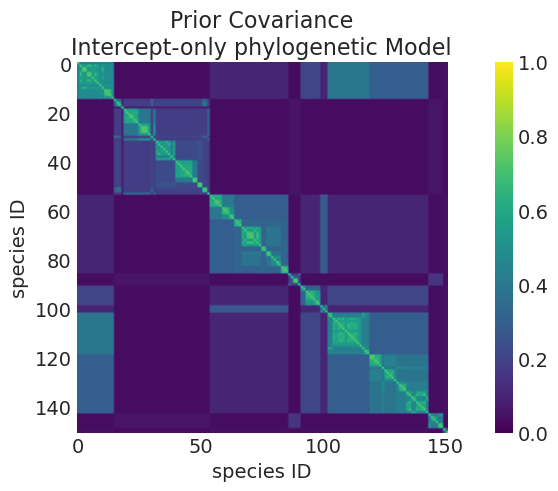

In [63]:
# Posterior
plot_mean_covariance_matrix(
    full_phylogenetic_mvn_inference.posterior,
    title='Prior Covariance\nIntercept-only phylogenetic Model'
)

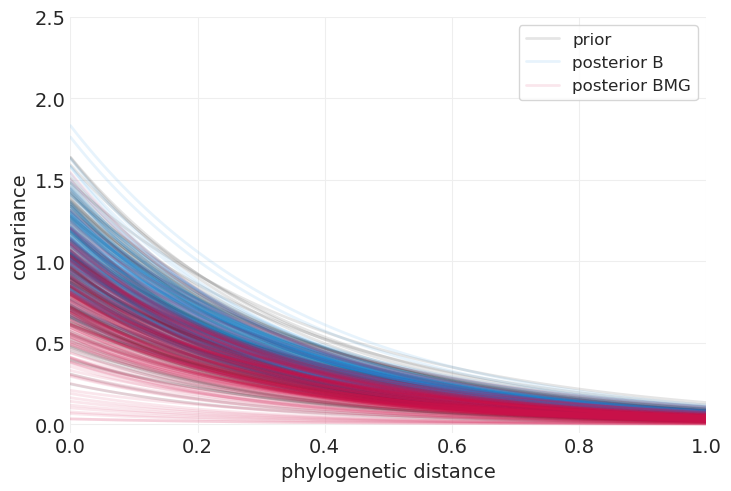

In [64]:
plot_predictive_kernel_function(intercept_only_phylogenetic_mvn_prior, label='prior', color='k')
plot_predictive_kernel_function(intercept_only_phylogenetic_mvn_inference.posterior, label='posterior B', color='C1')
plot_predictive_kernel_function(full_phylogenetic_mvn_inference.posterior, label='posterior BMG')

We can see that when including regressors for body mass and group size, the amount of phylogenetic covaration used to explain brain size is greatly diminished, compared to the phylogenetic-distance-only model.

The results for full-phylogenetic model reported here make sense to me too, given that we can explain away a lot of the variability in brain size by primarily body mass, after we've controlled for phylogenetic history; this in turn makes the phylogenetic history receive less weight in the model.

### Influence of Group Size on Brain Size

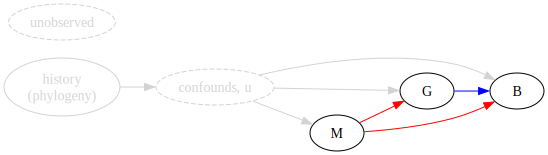

In [65]:
utils.draw_causal_graph(
    edge_list=[
        ("G", "B"),
        ("M", "G"),
        ("M", "B"),
        ("u", "M"),
        ("u", "G"),
        ("u", "B"),
        ("h", "u")
    ],
    node_props={
        "h": {"label": "history\n(phylogeny)", "color": "lightgray", "fontcolor": "lightgray"},
        "u": {"style": "dashed", "label": "confounds, u", "color": "lightgray", "fontcolor": "lightgray"},
        "unobserved": {"style": "dashed", "color": "lightgray", "fontcolor": "lightgray"},  
    },
    edge_props={
        ("G", "B"): {"color": "blue"},
        ("M", "G"): {"color": "red"},
        ("M", "B"): {"color": "red"},
        ("u", "B"): {"color": "lightgray"},
        ("u", "M"): {"color": "lightgray"},
        ("u", "G"): {"color": "lightgray"},
        ("h", "u"): {"color": "lightgray",}
    },
    graph_direction="LR"
)

- We ignore the confounds due to genetic history (light gray)
  - thus we don't try to control for potential confounds due to genetic history.
- To get <span style="color:blue">the direct effect of $G$ on $B$</span> we'll also stratify by $M$ to block <span style="color:red">the backdoor path through the fork passing through $M$ </span>.

In [66]:
with pm.Model() as ordinary_model:
    
    # Priors
    alpha = pm.Normal("alpha", 0, 1)
    beta_G = pm.Normal("beta_G", 0, 0.5)
    beta_M = pm.Normal("beta_M", 0, 0.5)

    # Independent species (equal variance)
    sigma = pm.Exponential("sigma", 1)
    K = np.eye(len(B)) * sigma
    
    mu = alpha + beta_G * G + beta_M * M

    pm.MvNormal("B", mu=mu, cov=K, observed=B)
    ordinary_inference = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_G, beta_M, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.


In [67]:
az.summary(ordinary_inference, var_names=["alpha", "beta_M", "beta_G"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.000,0.018,-0.033,0.035,0.0,0.0,4140.0,2988.0,1.0
beta_M,0.892,0.022,0.850,0.933,0.0,0.0,2740.0,2901.0,1.0
beta_G,0.124,0.022,0.080,0.165,0.0,0.0,2749.0,2734.0,1.0


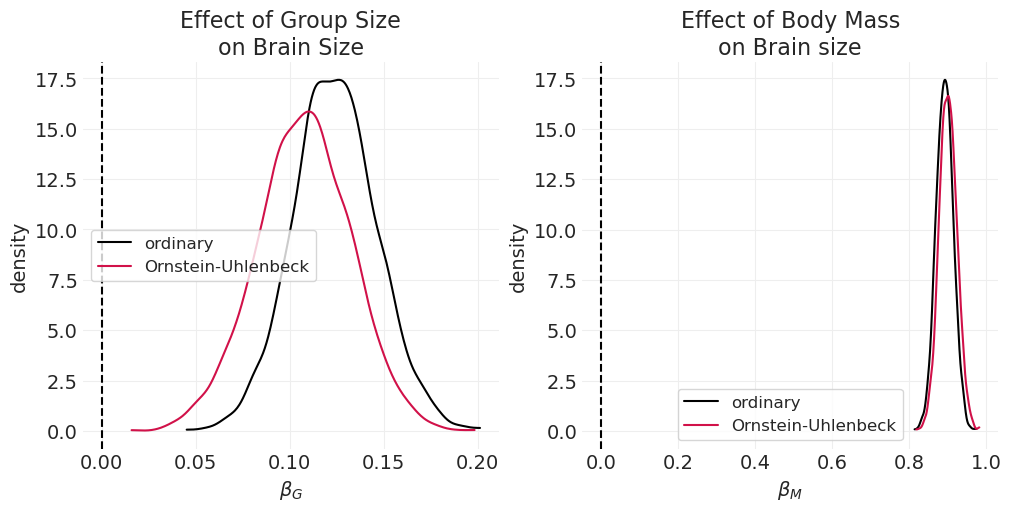

In [68]:
def plot_primate_posterior_comparison(variable, ax, title=None):
    az.plot_dist(ordinary_inference.posterior[variable], color='k', label='ordinary', ax=ax)
    az.plot_dist(full_phylogenetic_mvn_inference.posterior[variable], color='C0', label='Ornstein-Uhlenbeck', ax=ax)
    ax.axvline(0, color='k', linestyle='--');
    ax.set_xlabel(f"$\\{variable}$")
    ax.set_ylabel("density");
    ax.set_title(title)

_, axs = plt.subplots(1, 2, figsize=(10, 5))
plot_primate_posterior_comparison('beta_G', axs[0], "Effect of Group Size\non Brain Size")
plot_primate_posterior_comparison('beta_M', axs[1], "Effect of Body Mass\non Brain size")

By trying to control for potential confounds due to genetic history, we have nearly halved the estimated effect of Group size on Brain size $\beta_G$, though it's still mostly positive.

This estimator can also give us the direct effect of Body Mass $M$ on Brain Size $B$ (by blocking the Pipe through $G$). When we look at the $\beta_M$, we see that there is a slight increase in the effect of body mass on brain size when controlling for genetic history confounds, though the effect is large for both estimators indicating that body mass is a large driver of brain size.

## Summary: Phylogenetic Regression

#### Potential Issues

- What about uncertainty in phylogeny?
  - better to perform phylogenic inference simultaneously -- i.e. estimate a posterior on phylogenies
- What about reciprocal causation?
  - feedback between organism and environment
  - there's no unidirectional cause
  - thus regression is likely not the best option
  - new were methods include differential equations to pose the problem as a multi-objective optimization problem

## Summary: Gaussian Processes
- Provides means for (local) partial pooling for continuous groups/categories
- General approximation engine -- good for prediction
- Robust to overfitting
- Sensitive to priors: prior predictive simiulation is very important